<a href="https://colab.research.google.com/github/broadinstitute/BEClust3D/blob/add_qc/BEClust3D_v1_MultiScreen_SingleGene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary Steps

In [1]:
# @title Imports
# @markdown Import BEClust3D from Github and other necessary packages
! pip uninstall beclust3d -y
! pip install git+https://github.com/broadinstitute/BEClust3D.git@add_qc
! pip install pandas
! pip install numpy
! pip install matplotlib

Found existing installation: beclust3d 2024.0.0
Uninstalling beclust3d-2024.0.0:
  Successfully uninstalled beclust3d-2024.0.0
  Cloning https://github.com/broadinstitute/BEClust3D.git (to revision add_qc) to /tmp/pip-req-build-j5ph9gj9
  Running command git clone --filter=blob:none --quiet https://github.com/broadinstitute/BEClust3D.git /tmp/pip-req-build-j5ph9gj9
  Running command git checkout -b add_qc --track origin/add_qc
  Switched to a new branch 'add_qc'
  Branch 'add_qc' set up to track remote branch 'add_qc' from 'origin'.
  Resolved https://github.com/broadinstitute/BEClust3D.git to commit 33e6a9a592e4178f54d11ea468e53a4acd7c0e43
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for beclust3d: filename=beclust3d-2024.0.0-py3-none-any.whl size=8710262 sha256=b031780bb14064019d8497bf050b09eefc7360c13f0d11078f4ce63c6d9d2a4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-gdgpd

In [8]:
# @title Imports
# @markdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets

In [3]:
# @title Import Google Drive
# @markdown Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# @markdown If files are in Google Drive, add 'drive/' in front of path
workdir = 'drive/MyDrive/beclust3d/' # @param {type:"string"}

In [29]:
# @markdown Separate screen file names by comma


screens = 'Human_InVitro_294T_Apobec_D14_Input.txt, Human_InVitro_294T_TadA_D14_Input.txt' # @param {type:"string"}
screens = screens.split(', ')

input_gene = 'SETDB1' # @param {type:"string"}
input_uniprot = 'Q15047' # @param {type:"string"}
structureid = f"AF-{input_uniprot}-F1-model_v4"

Human_InVitro_294T_Apobec_D14_Input.txt, Human_InVitro_294T_TadA_D14_Input.txt, Human_InVitro_SK-ES_Apobec_D14_Input.txt, Human_InVitro_SK-ES_TadA_D17_Input.txt, Human_InVitro_SW480_Apobec_D14_Input.txt, Human_InVitro_SW480_TadA_D14_Input.txt, Mouse_InVivo_B16_Apobec_NSG_Input.txt, Mouse_InVivo_B16_Apobec_Tx_NSG.txt, Mouse_InVivo_B16_TadA_NSG_Input.txt, Mouse_InVivo_B16_TadA_Tx_NSG.txt, Mouse_InVivo_LLC_Apobec_NSG_Input.txt, Mouse_InVivo_LLC_Apobec_Tx_NSG.txt

# Formatting Data for Input (Optional)

In [30]:
# @markdown Prioritize mutations helper function

# Function to determine the Mutation_Category based on Mutation_Type
def prioritize_mutations(mutation_types):
    if not mutation_types or pd.isna(mutation_types):
        return "No Mutation"
    mutation_list = mutation_types.split(', ')

    # Replace "Splice-donor" and "Splice-acceptor" with "Splice Site"
    mutation_list = ["Splice Site" if "Splice" in mutation else mutation for mutation in mutation_list]
    # Filter out mutation types not in the hierarchy list
    mutation_list = [mutation for mutation in mutation_list if mutation in mutation_hierarchy]

    # If no recognized mutation types are found, return an empty string
    if not mutation_list:
        return ""
    # Sort the mutations based on the defined hierarchy
    mutation_list.sort(key=lambda x: mutation_hierarchy.get(x, float('inf')))

    return mutation_list[0]

def count_commas(s):
    if pd.isna(s):
        return 0
    return s.count(',')

In [31]:

# @markdown If MUT_COL and EDITS_COL are a list of mutations and edits as opposed to one category, this code chunk reformats them into separate rows. Otherwise, an error is thrown.

mut_list_col = "Mutation_Category" # @param {type:"string"}
mut_col = "Histogram_Category" # @param {type:"string"}
val_col = "Input" # @param {type:"string"}
gene_col = "TargetGeneSymbol" # @param {type:"string"}
edits_col = "AminoAcidEdits" # @param {type:"string"}
gRNA_col = "gRNA_seq" # @param {type:"string"}

# @markdown If your data does not have a single mutation type for each score \
# @markdown Establish a hierarchy for mutation type importance \
# @markdown This will overwrite the MUT_COL column of your dataframe

assign_hierachy = True #@param {type: "boolean"}
hierachy = "Nonsense, Splice Site, Missense, Intron, Silent, UTR, Flank, No Mutation" # @param {type:"string"}
hierachy_list = [x.strip() for x in hierachy.split(',')]
mutation_hierarchy = {mutation: idx for idx, mutation in enumerate(hierachy_list)}

# CHECK INPUT #
for i, screen in enumerate(screens):
  df_screen = pd.read_csv(f'{workdir}rawdata/{screen}', sep='\t')
  assert all(x in df_screen.columns for x in [mut_list_col, mut_col, val_col, gene_col, edits_col]), "Input column(s) are not in the dataframe"
  # assert all(x in df_screen.columns for x in [mut_list_col, mut_col, val_col, gene_col, edits_col, gRNA_col]), "Input column(s) are not in the dataframe"

  # CHECK VAL_COL a list of values
  assert all(isinstance(x, float) for x in df_screen[val_col]), "val_col is not an float"

  # CHECK GENE_COL a list of gene names
  unique_genes = df_screen[gene_col].unique()
  unique_genes.sort()
  print(f'All genes present in screen {screen}', unique_genes)
  assert all(isinstance(x, str) for x in df_screen[gene_col]), "gene_col is not a string"

  # # CHECK gRNA_COL
  # assert all(isinstance(x, str) for x in df_screen[gRNA_col]), "gRNA_col is not a string"
  # assert all(len(x)==20 for x in df_screen[gRNA_col]), "gRNA_col should be 20 bps"

  # CHECK MUT_LIST_COL and EDITS_COL MATCH
  mismatch_rows = df_screen[df_screen[mut_list_col].apply(lambda x: count_commas(x)) != df_screen[edits_col].apply(lambda x: count_commas(x))]
  assert mismatch_rows.empty, "MUT_LIST_COL and EDITS_COL do not match"
  if not mismatch_rows.empty:
    print('Check the following rows')
    print(df_screen[mismatch_rows])

  # PRIORITIZE MUT_COL BASED ON MUT_LIST_COL
  if assign_hierachy:
    df_screen[mut_col] = df_screen[mut_list_col].apply(lambda x: prioritize_mutations(x))
    new_screen = screen.split('.')[0]+'_prioritized.'+screen.split('.')[1]
    print(screen, 'renamed to', new_screen)
    df_screen.to_csv(f'{workdir}rawdata/{new_screen}', sep='\t', index=False)
    screens[i] = new_screen


All genes present in screen Human_InVitro_294T_Apobec_D14_Input.txt ['ATF7IP' 'ATF7IP2' 'EHMT1' 'EHMT2' 'MORC2' 'MPHOSPH8' 'PPHLN1' 'PTPN2'
 'SETDB1' 'SETDB2' 'SUV39H1' 'SUV39H2' 'TASOR' 'TRIM28']
Human_InVitro_294T_Apobec_D14_Input.txt renamed to Human_InVitro_294T_Apobec_D14_Input_prioritized.txt
All genes present in screen Human_InVitro_294T_TadA_D14_Input.txt ['ATF7IP' 'ATF7IP2' 'EHMT1' 'EHMT2' 'MORC2' 'MPHOSPH8' 'PPHLN1' 'PTPN2'
 'SETDB1' 'SETDB2' 'SUV39H1' 'SUV39H2' 'TASOR' 'TRIM28']
Human_InVitro_294T_TadA_D14_Input.txt renamed to Human_InVitro_294T_TadA_D14_Input_prioritized.txt


# Preprocess Screens, and Query Structure and Conservation

ATF7IP: Mean + STD
Missense: 0.03 + 0.766
No Mutation: 0.022 + 0.63
Nonsense: -0.226 + 0.842
Silent: 0.136 + 0.809
Splice Site: -0.816 + 0.833
ATF7IP2: Mean + STD
Missense: 0.104 + 0.678
No Mutation: 0.013 + 0.674
Nonsense: -0.077 + 0.547
Silent: 0.278 + 1.064
Splice Site: -0.291 + 0.196
EHMT1: Mean + STD
Missense: 0.024 + 0.701
No Mutation: 0.022 + 0.761
Nonsense: -0.199 + 0.792
Silent: 0.085 + 0.661
Splice Site: -0.323 + 0.898
EHMT2: Mean + STD
Missense: 0.002 + 0.721
No Mutation: -0.077 + 1.049
Nonsense: -0.098 + 0.715
Silent: 0.093 + 0.657
Splice Site: -0.103 + 0.774
MORC2: Mean + STD
Missense: -0.042 + 0.732
No Mutation: -0.01 + 0.724
Nonsense: -0.239 + 0.937
Silent: -0.073 + 0.702
Splice Site: -0.534 + 0.346
MPHOSPH8: Mean + STD
Missense: -0.096 + 0.7
No Mutation: 0.079 + 0.744
Nonsense: -0.495 + 0.891
Silent: -0.086 + 0.594
Splice Site: -0.564 + 0.418
PPHLN1: Mean + STD
Missense: 0.005 + 0.683
No Mutation: -0.002 + 0.498
Nonsense: -0.167 + 0.955
Silent: 0.163 + 0.705
Splice Site

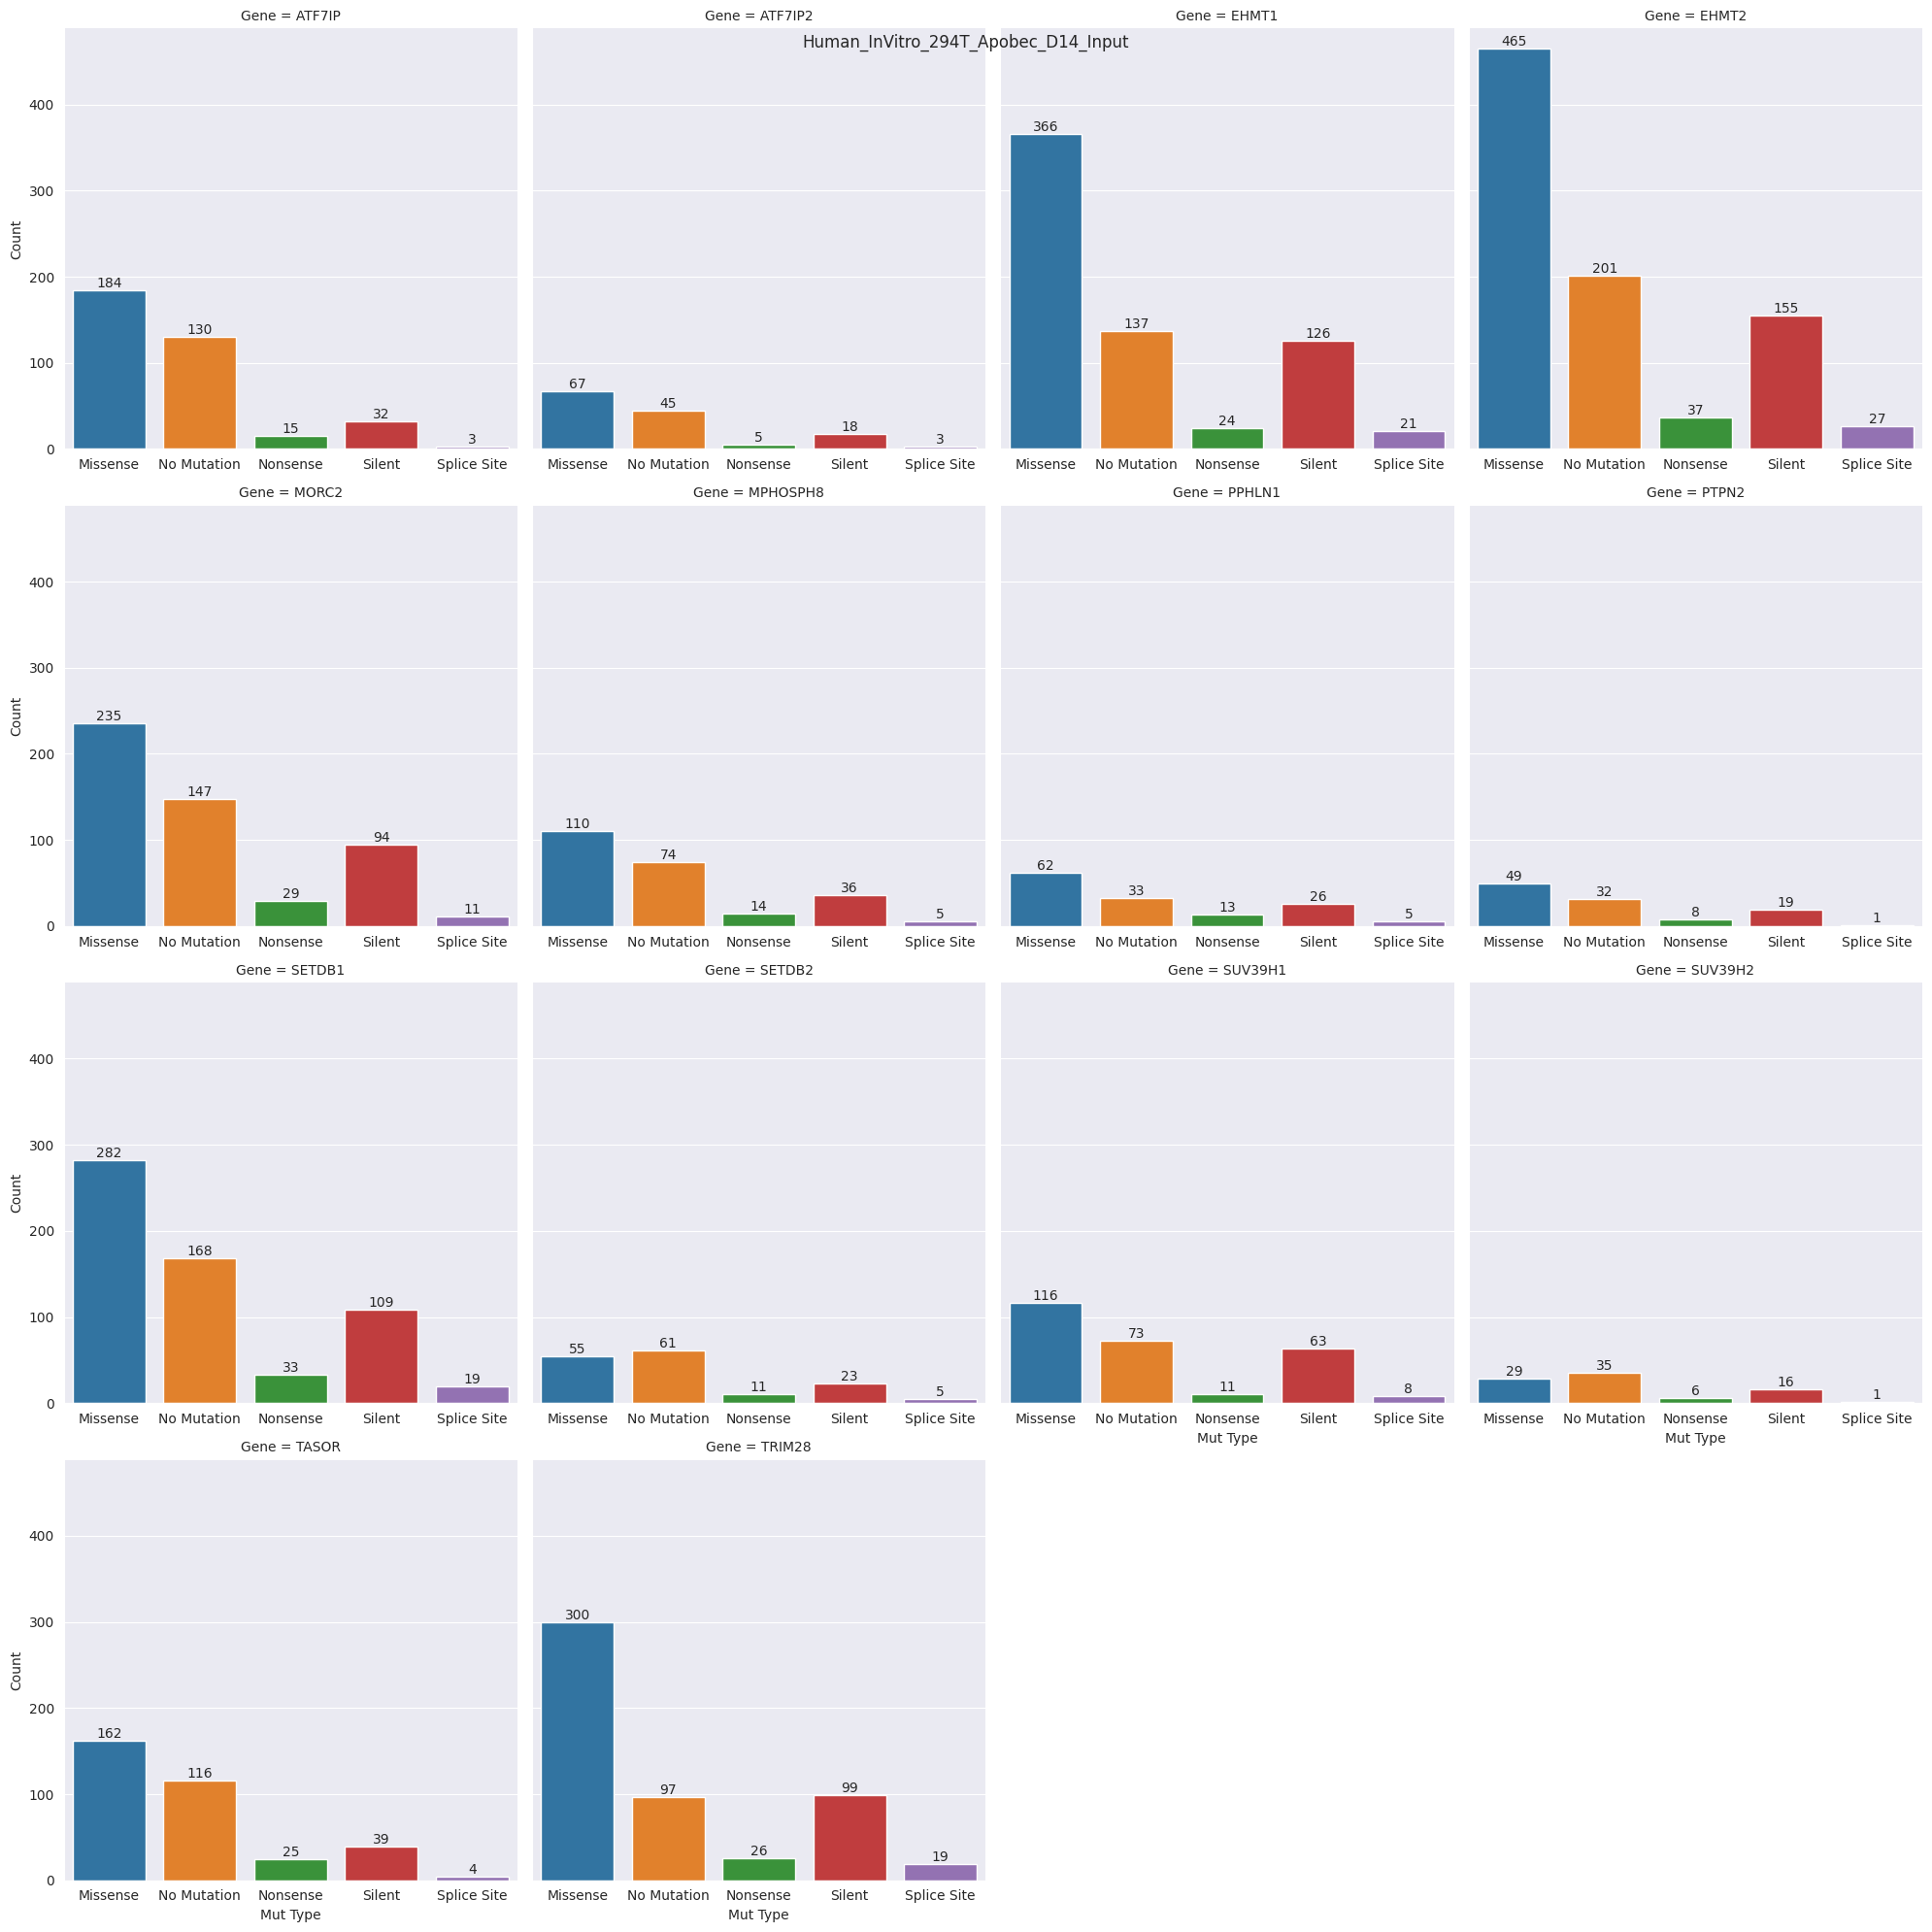

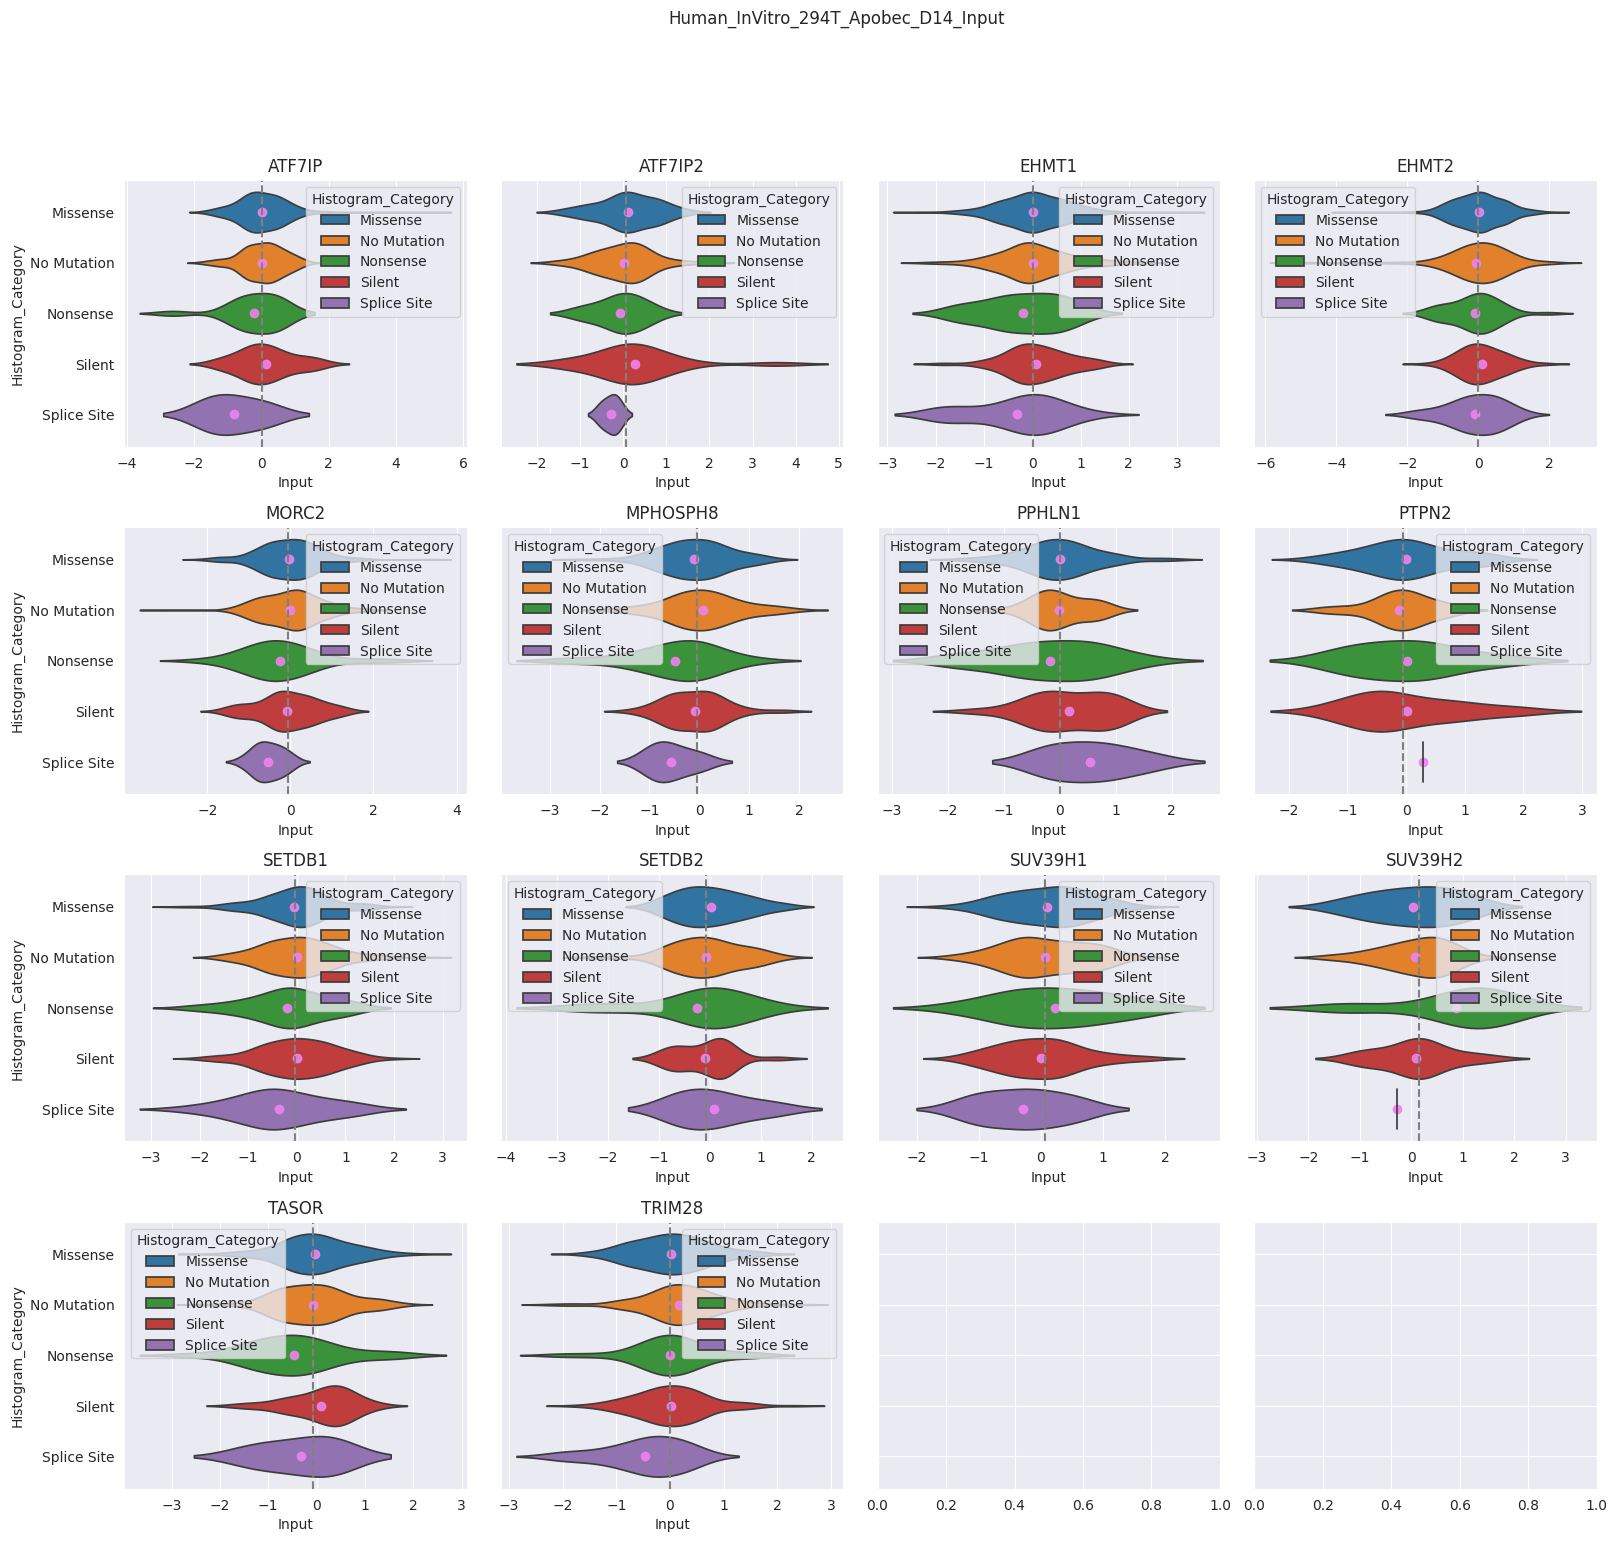

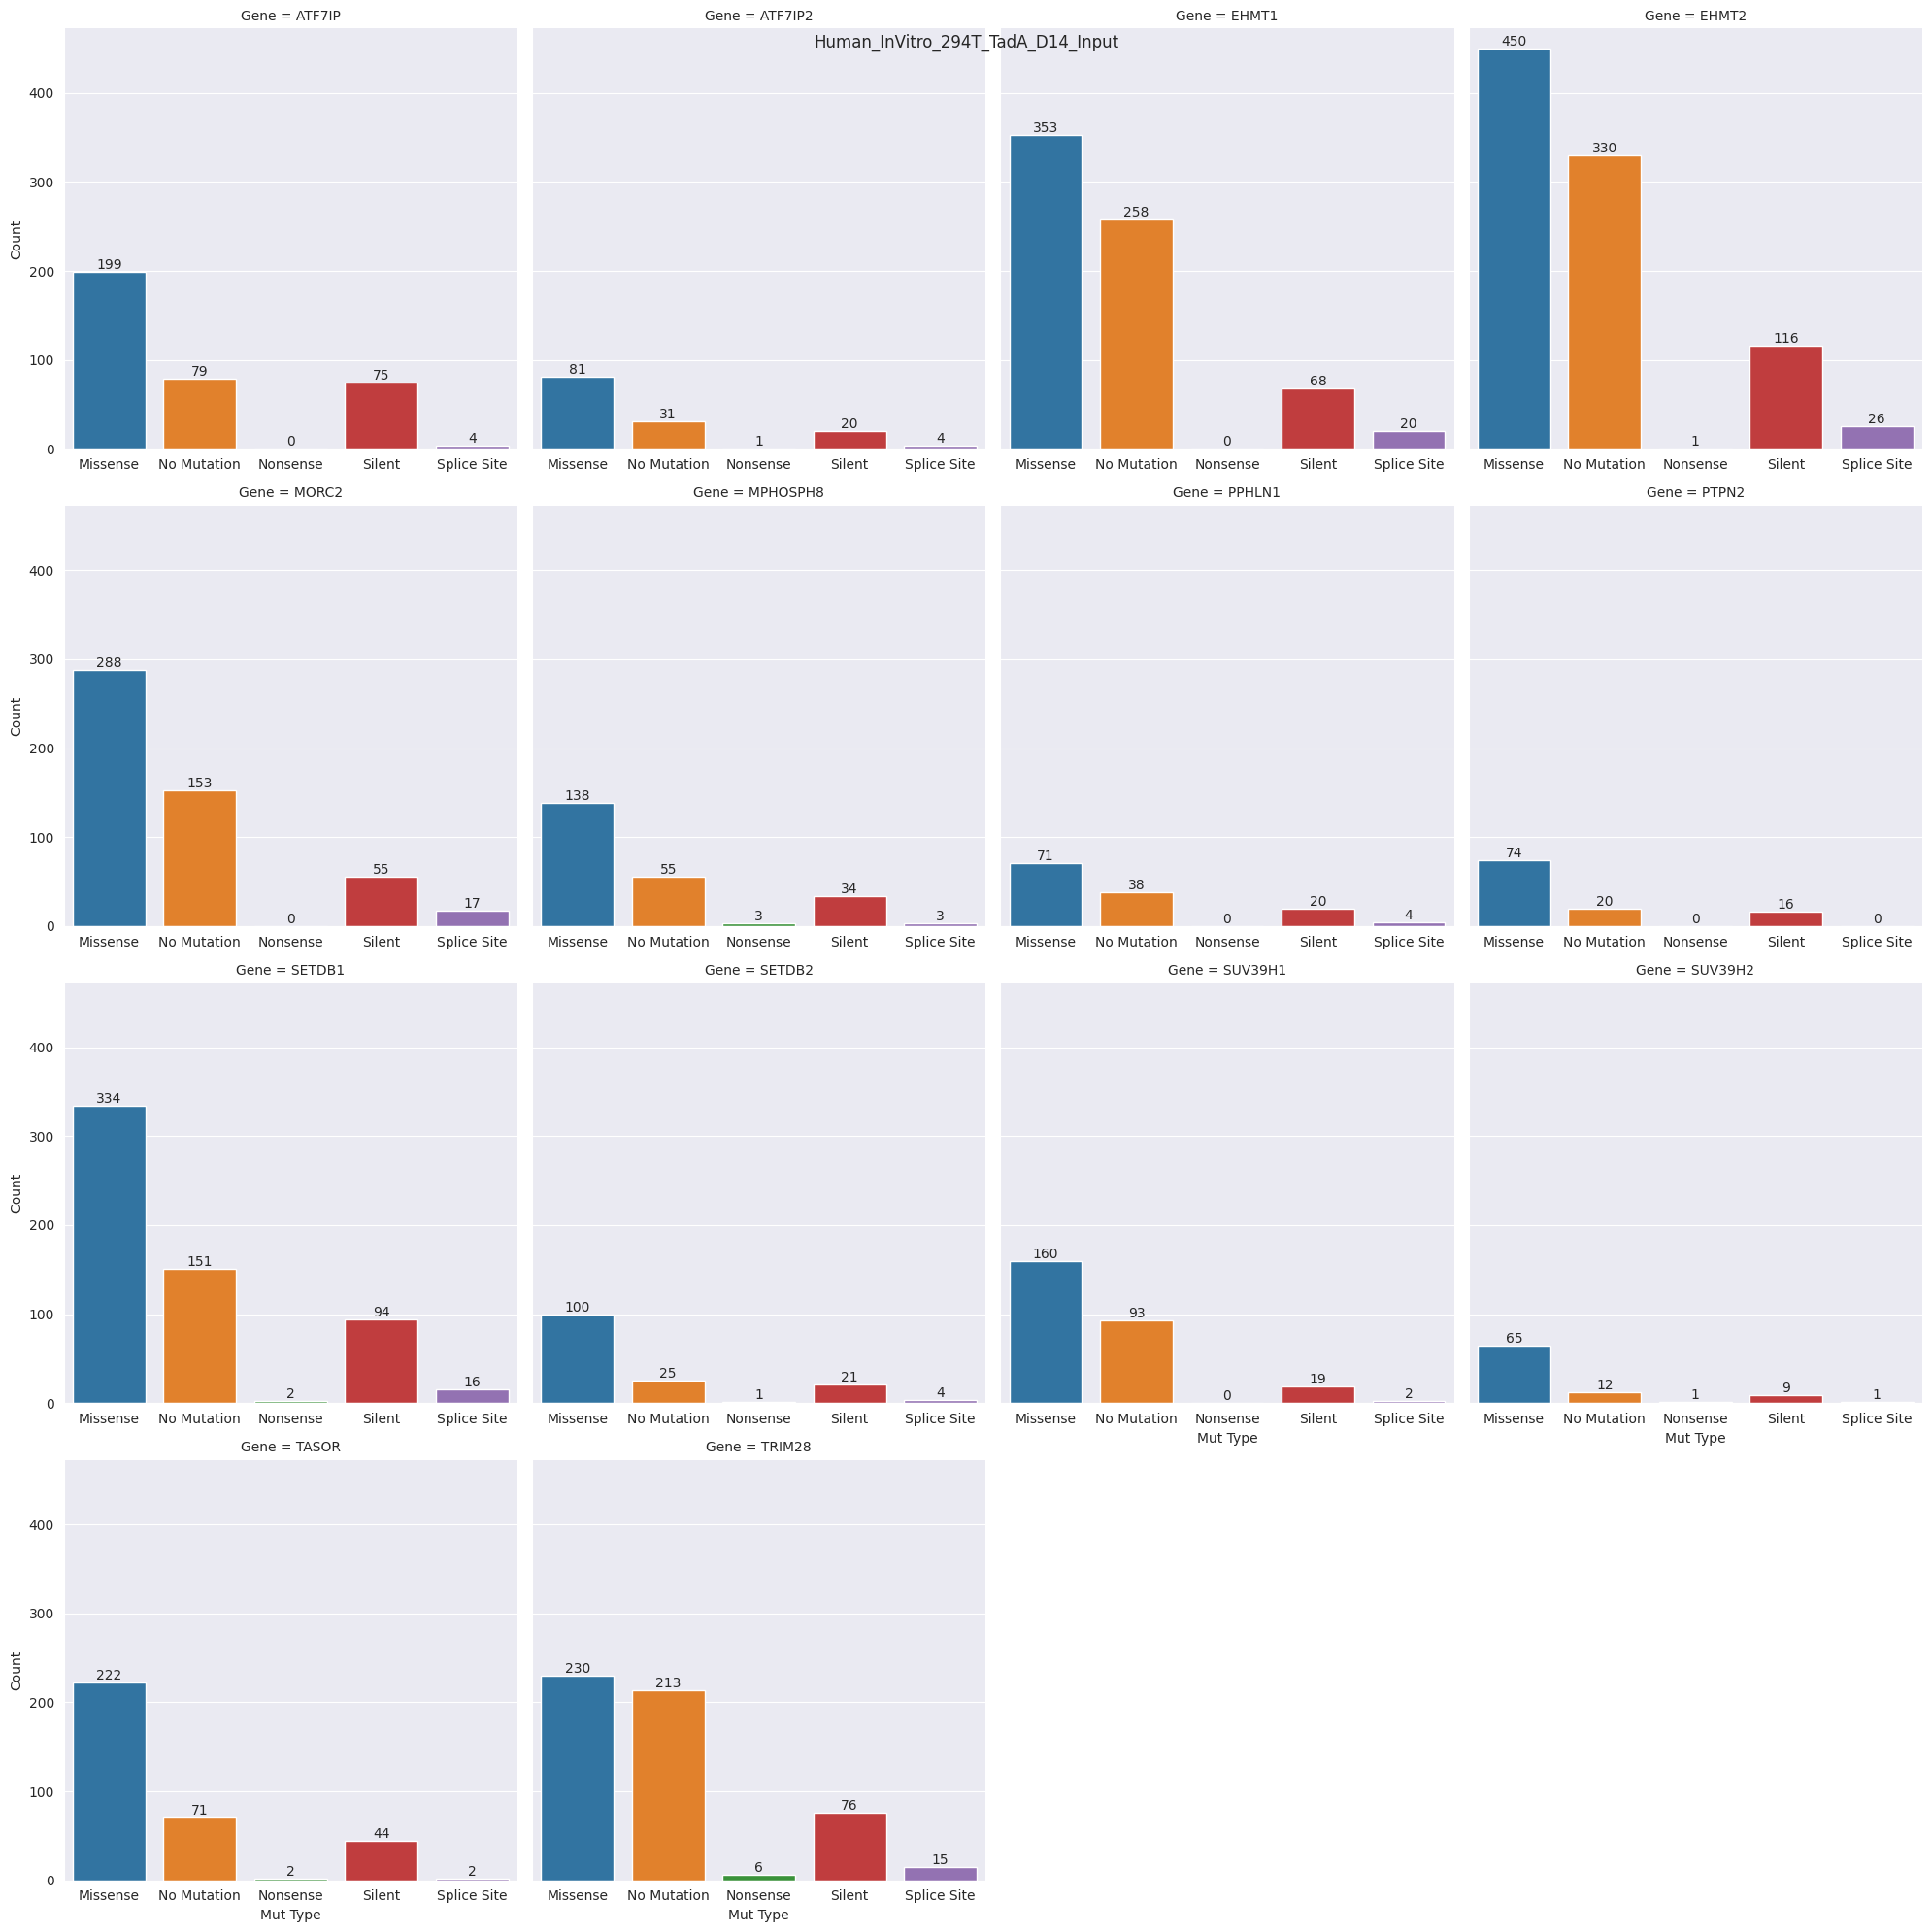

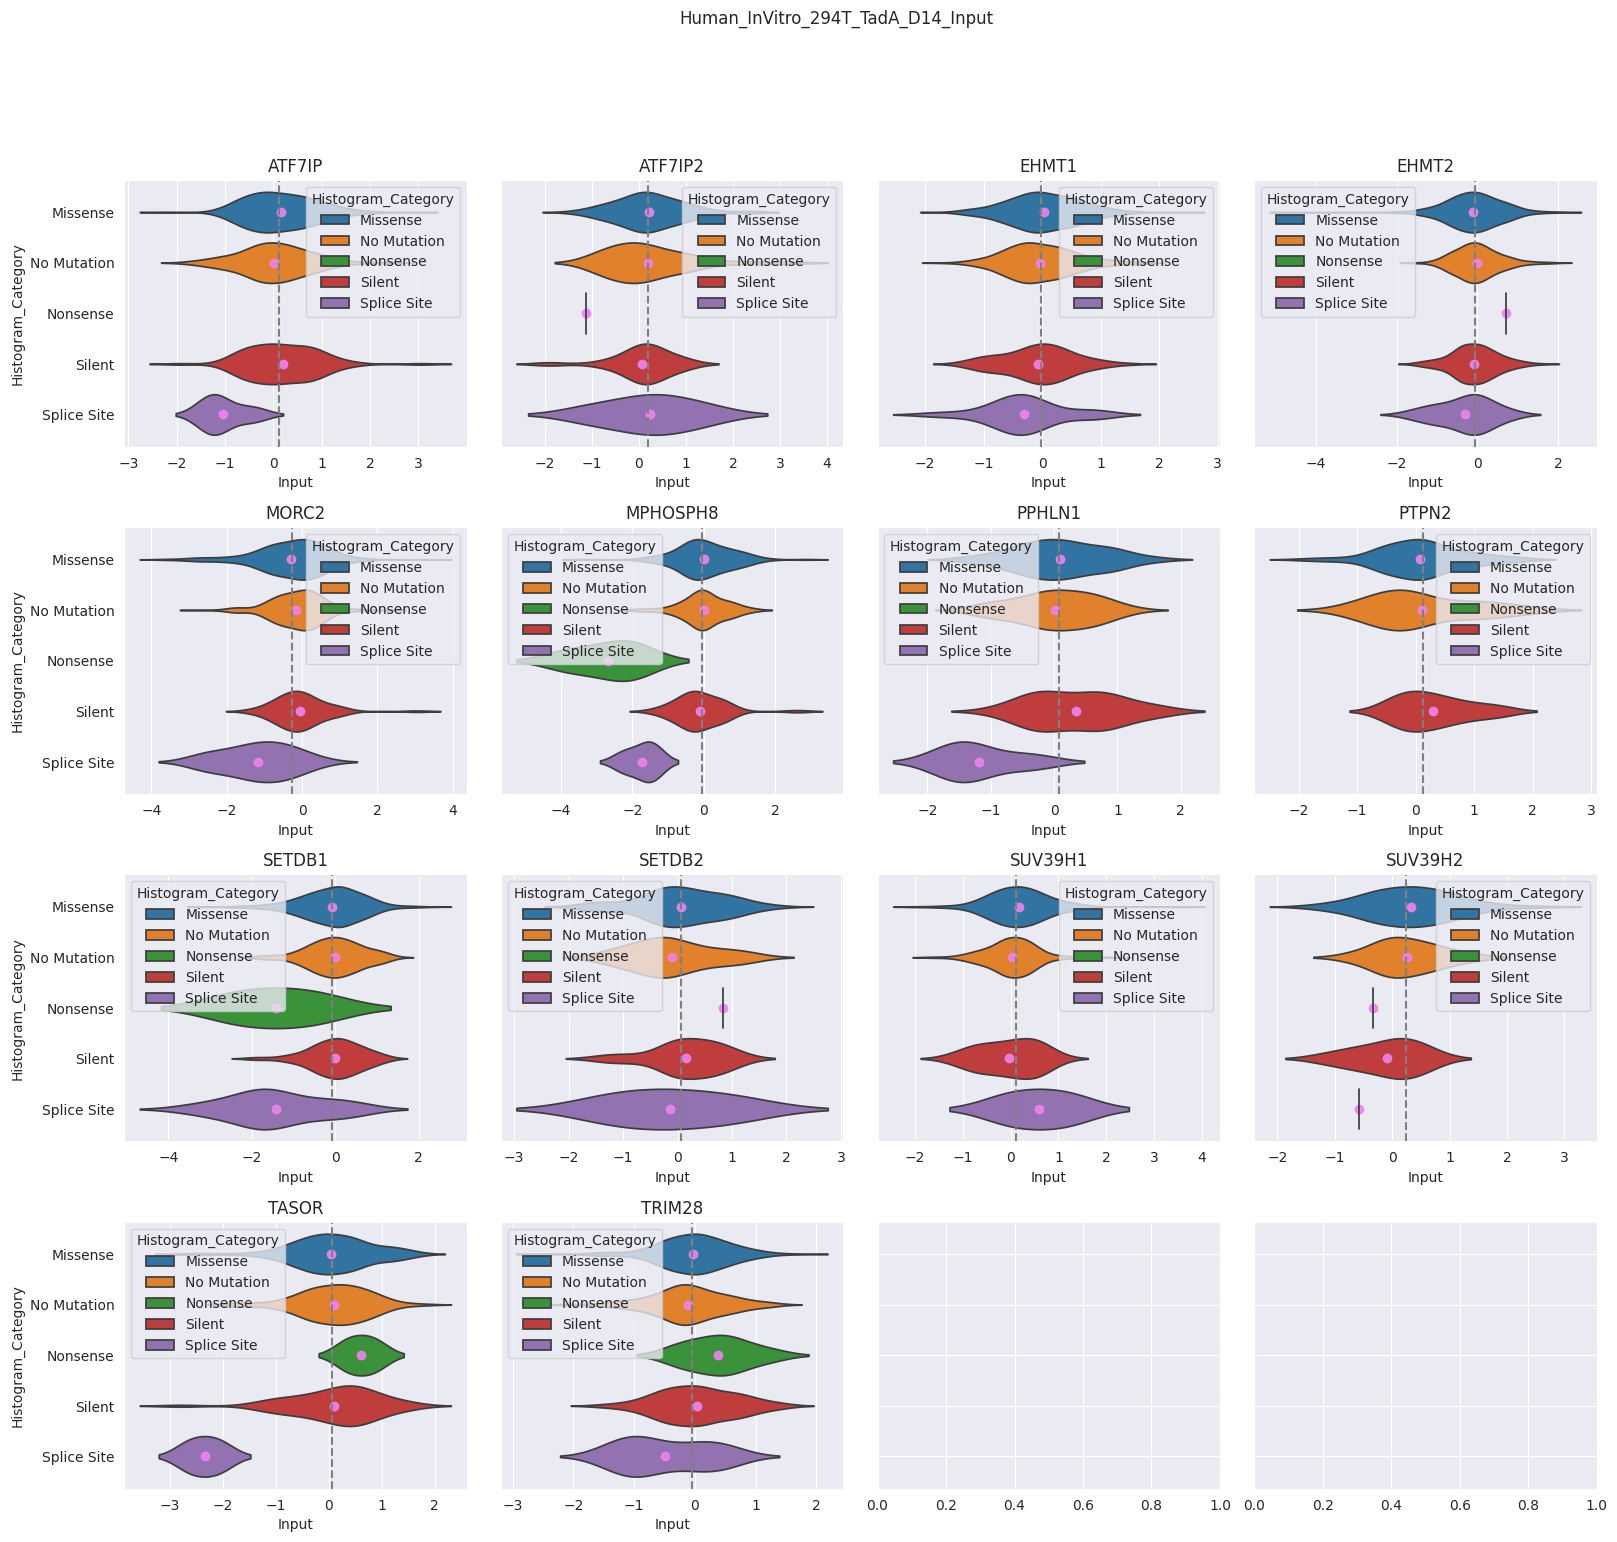

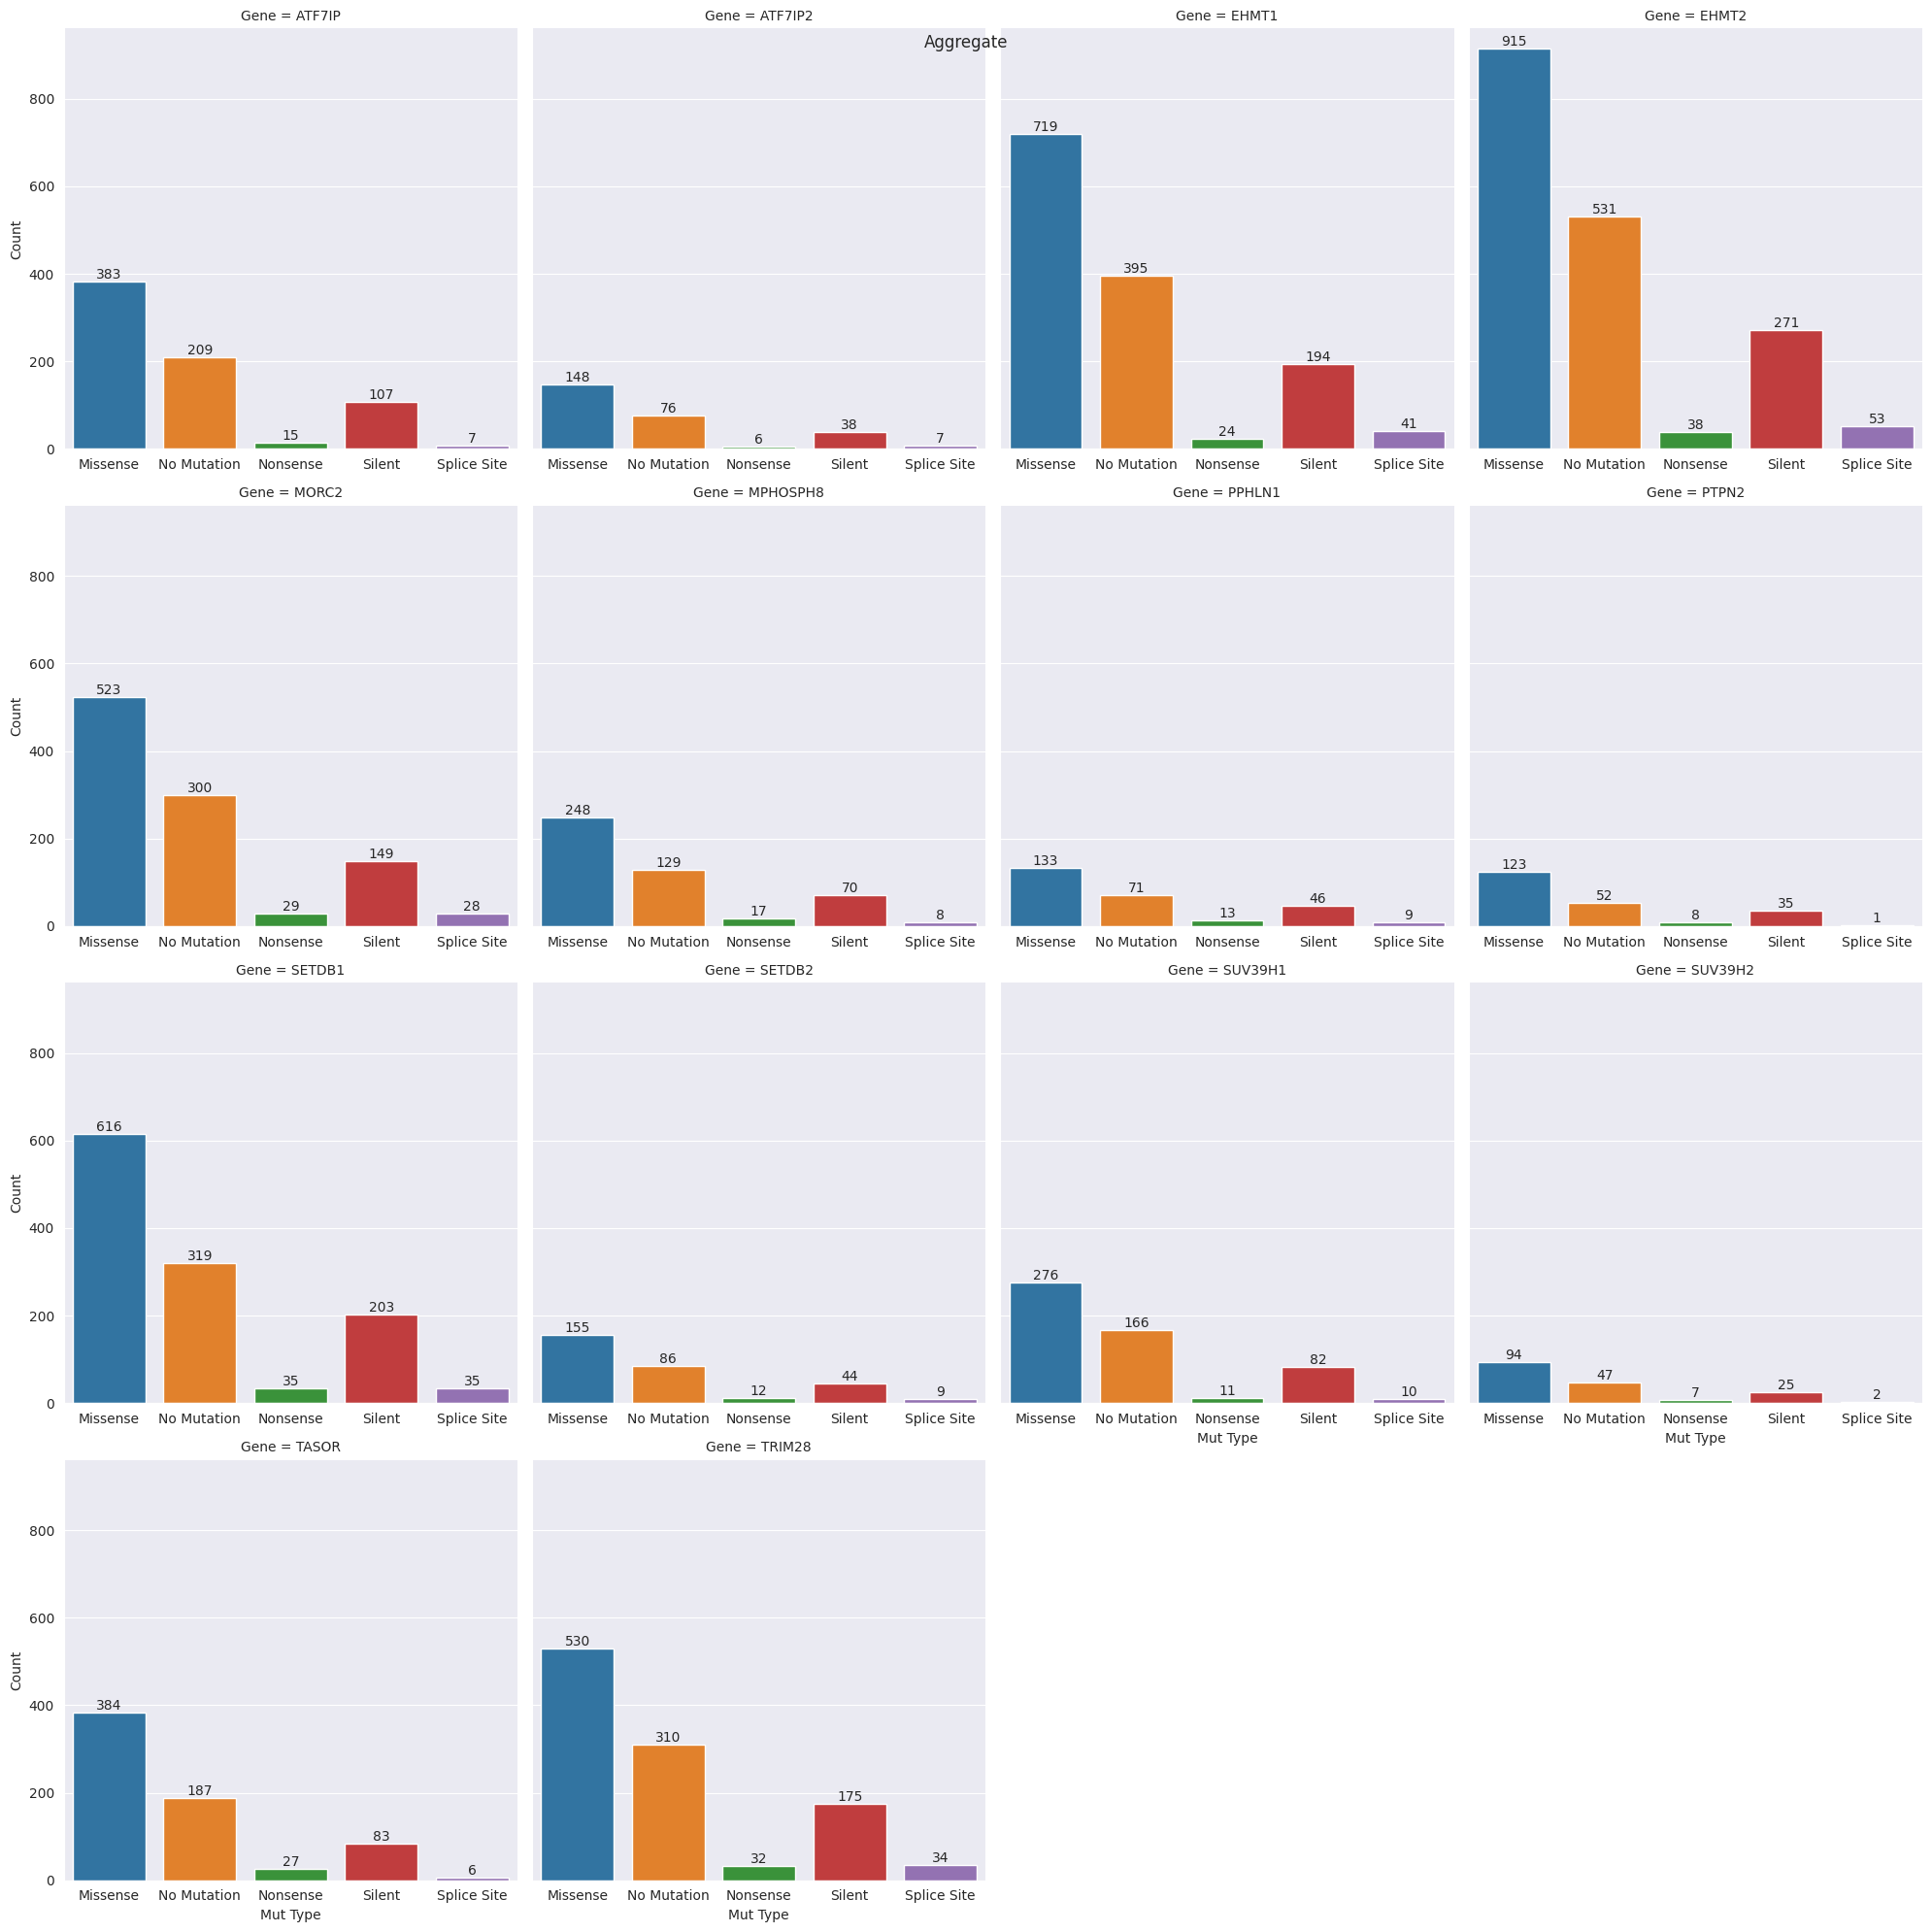

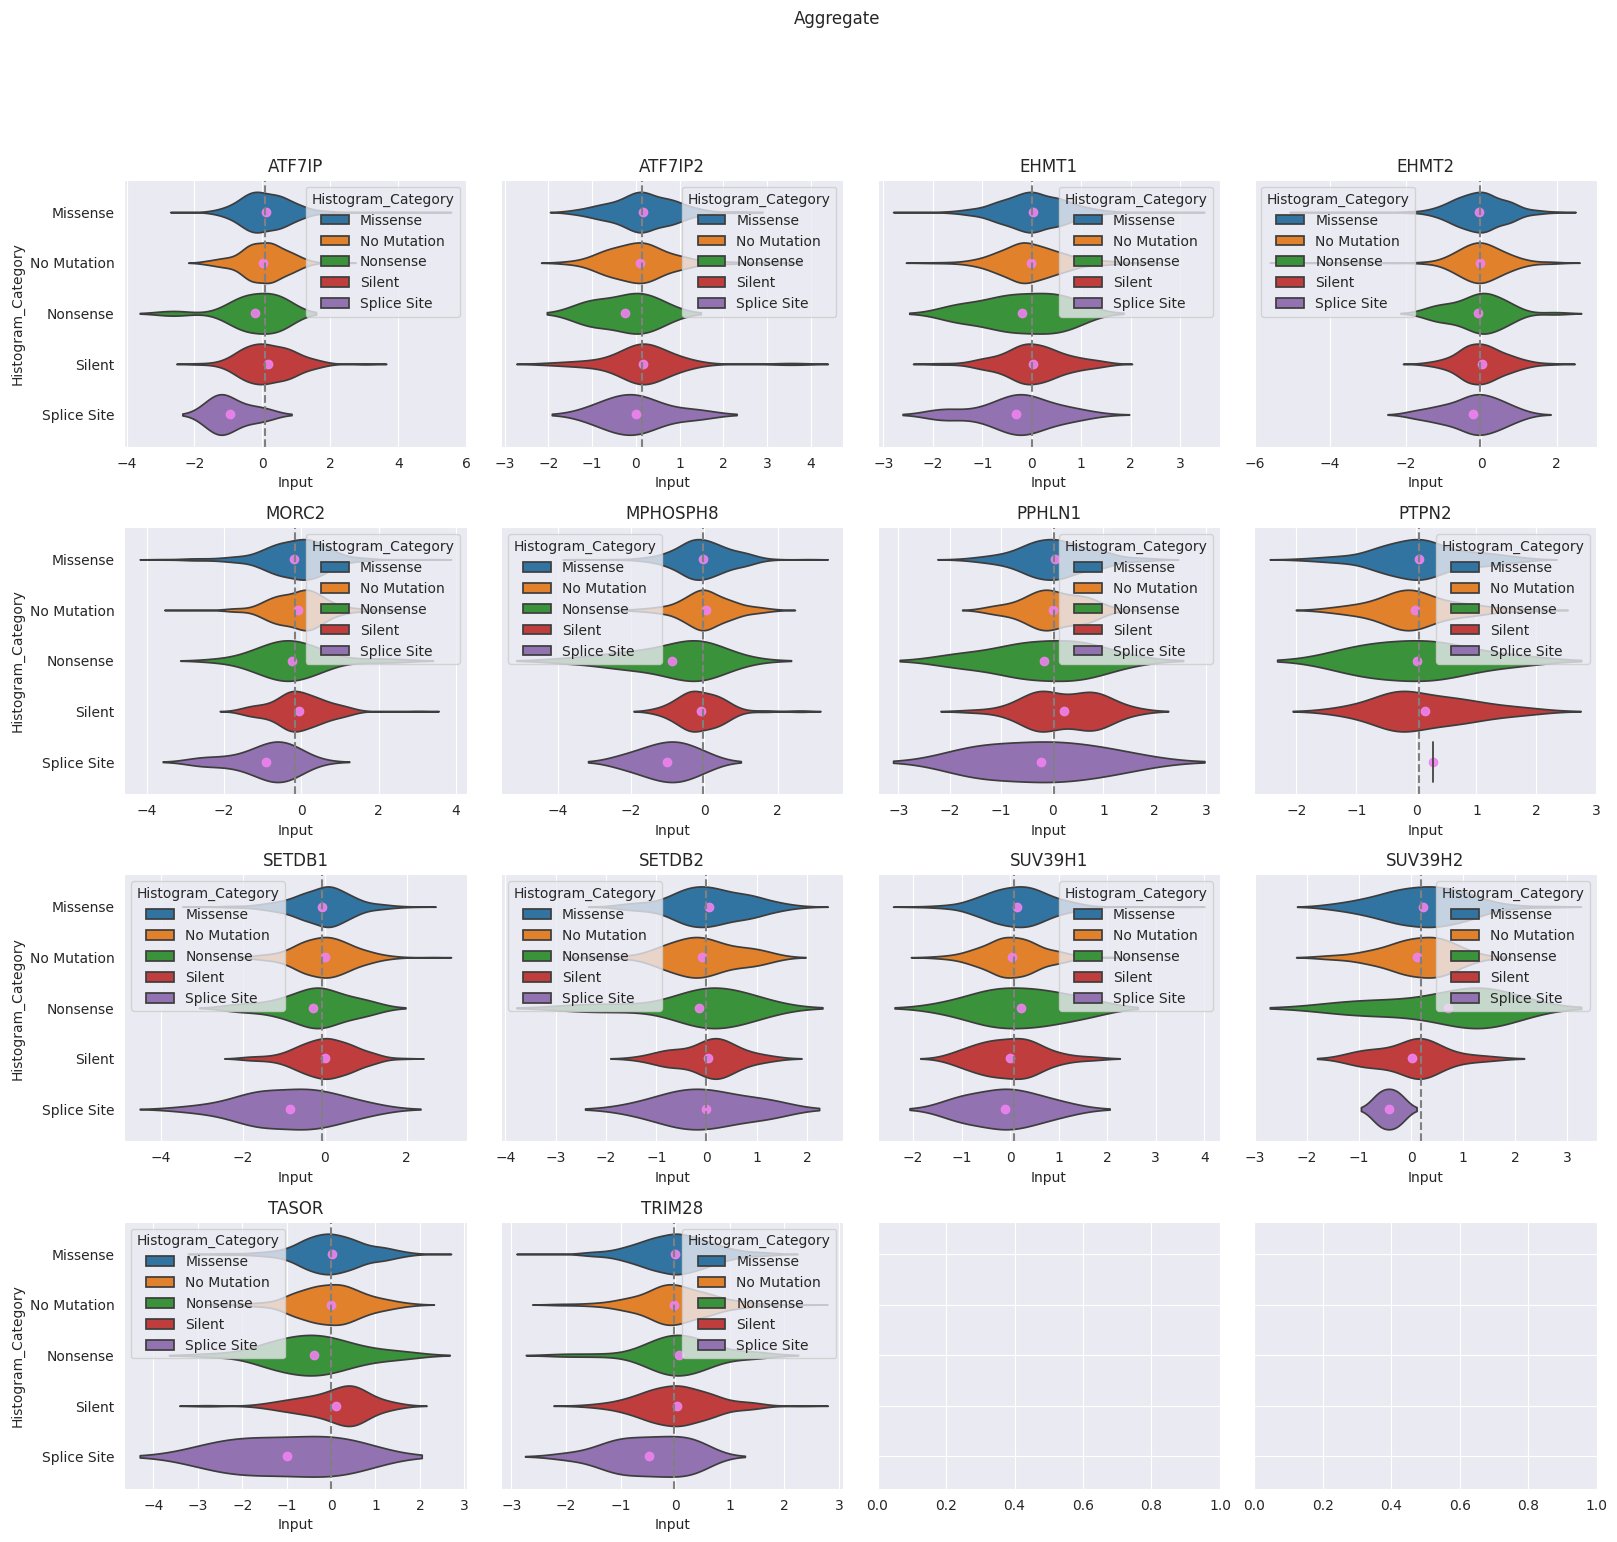

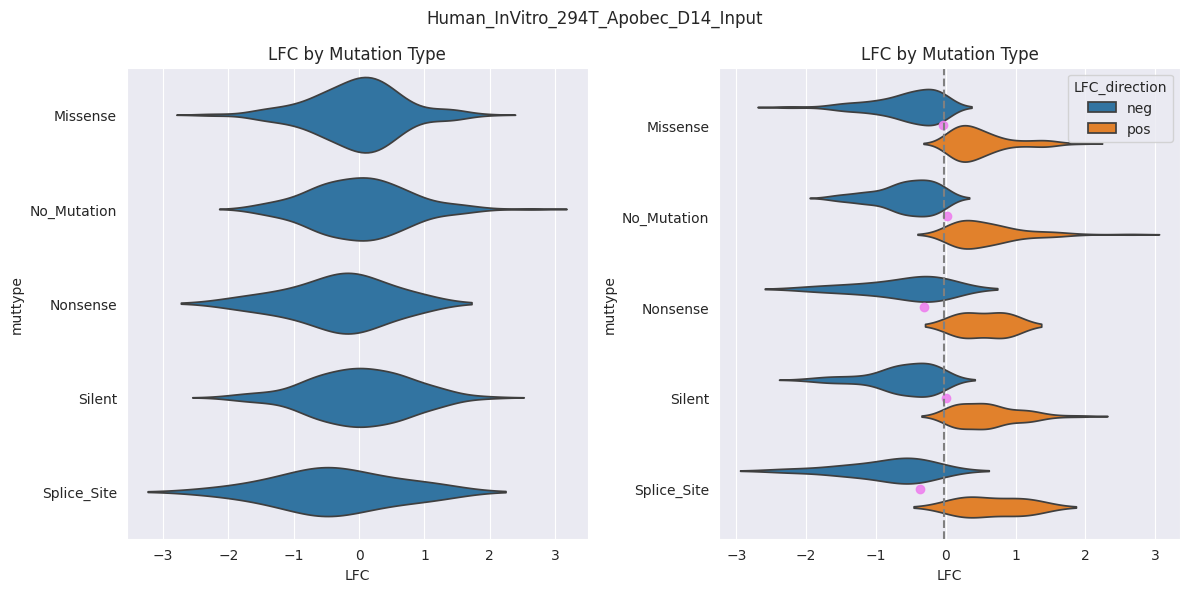

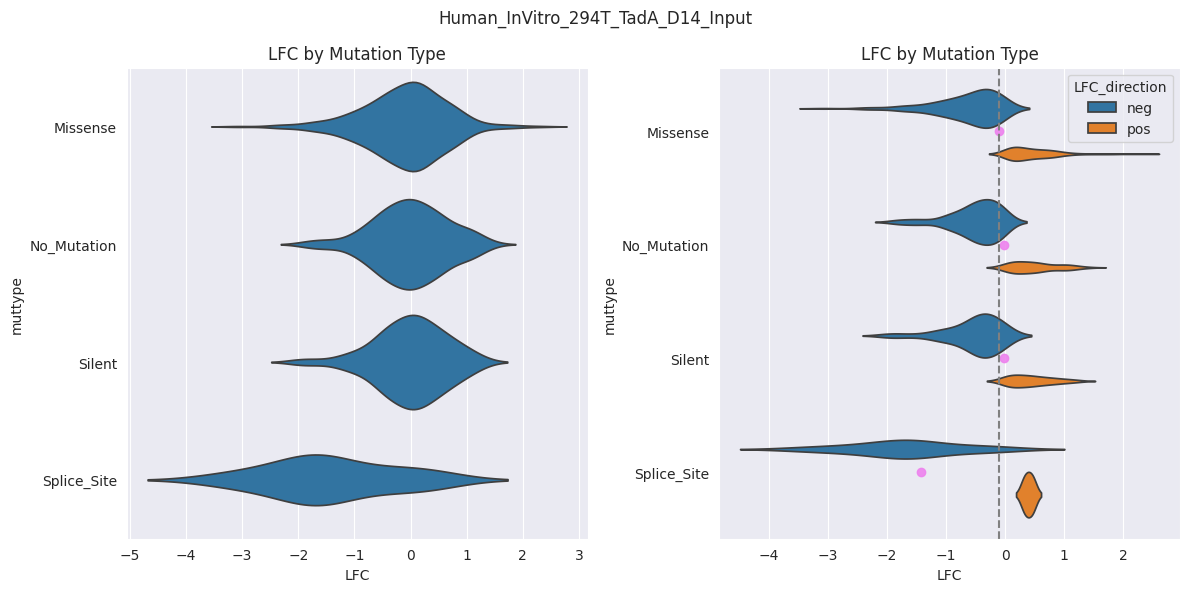

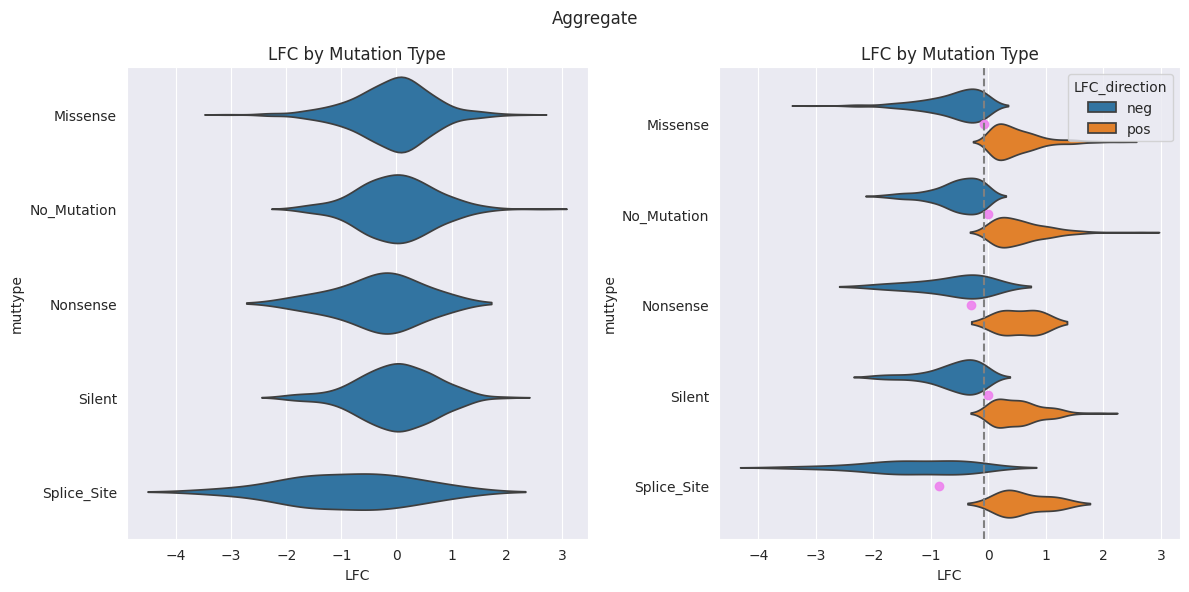

In [7]:
# @markdown Preprocess screen data and QC plots

from beclust3d.preprocess_be_results import parse_base_editing_results

df_inputs = [pd.read_csv(f'{workdir}rawdata/{screen}', sep='\t') for screen in screens]
_ = parse_base_editing_results(
    df_Inputs = df_inputs,
    workdir = workdir, input_gene = input_gene, input_screens = screens,
    mut_col=mut_col, val_col=val_col, gene_col=gene_col, edits_col=edits_col,
    )

Cases: ['Nonsense', 'Splice Site']
Controls: ['Silent', 'Flank']


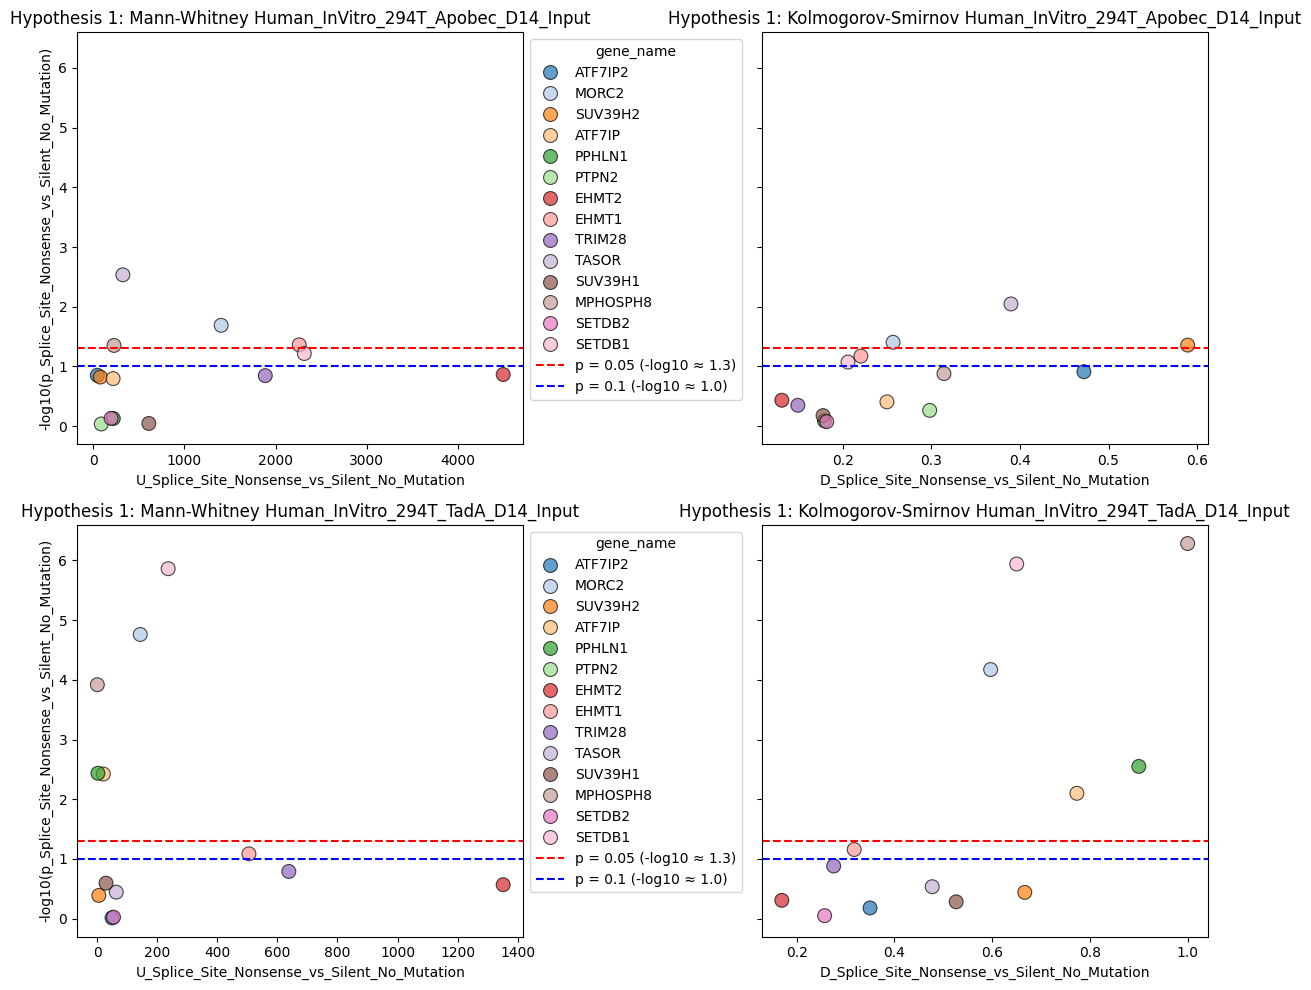

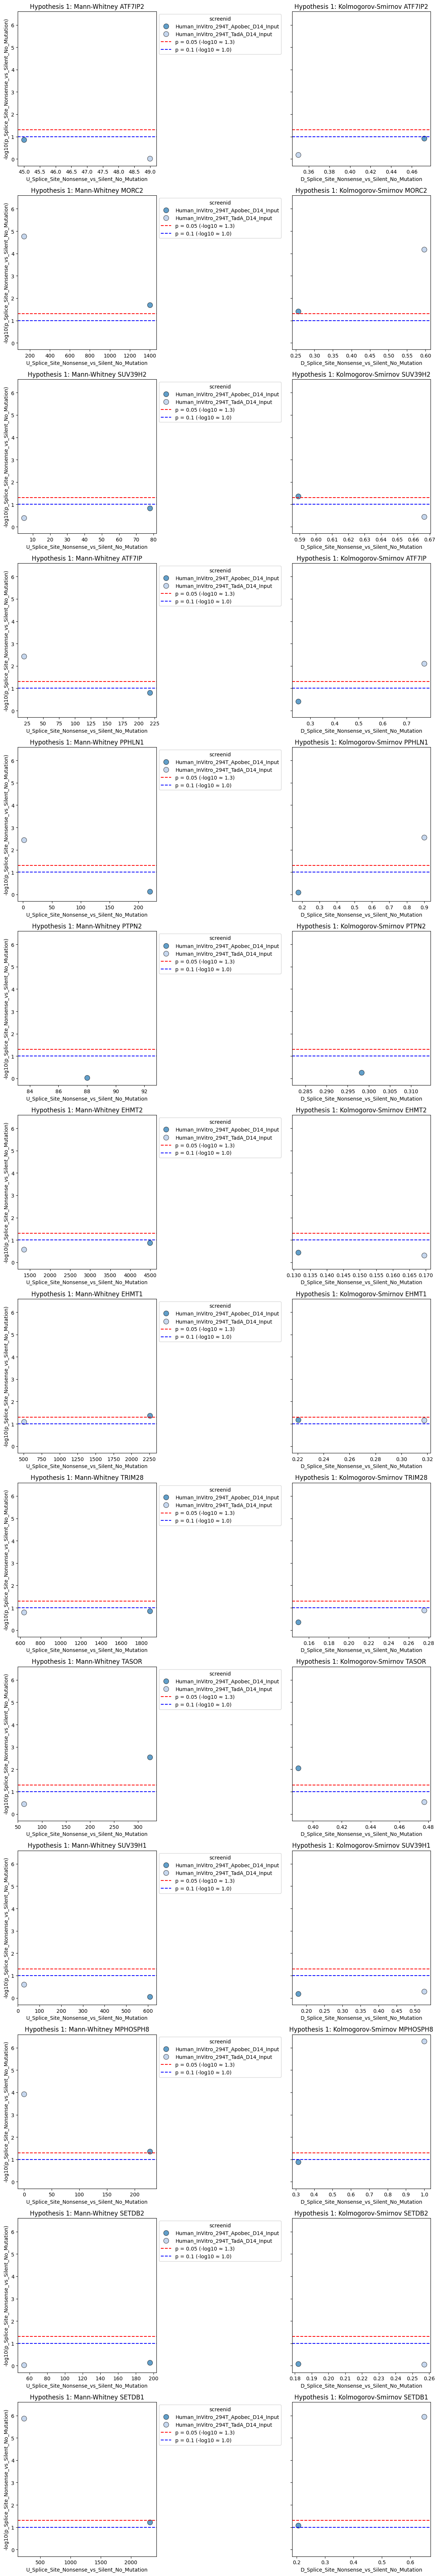

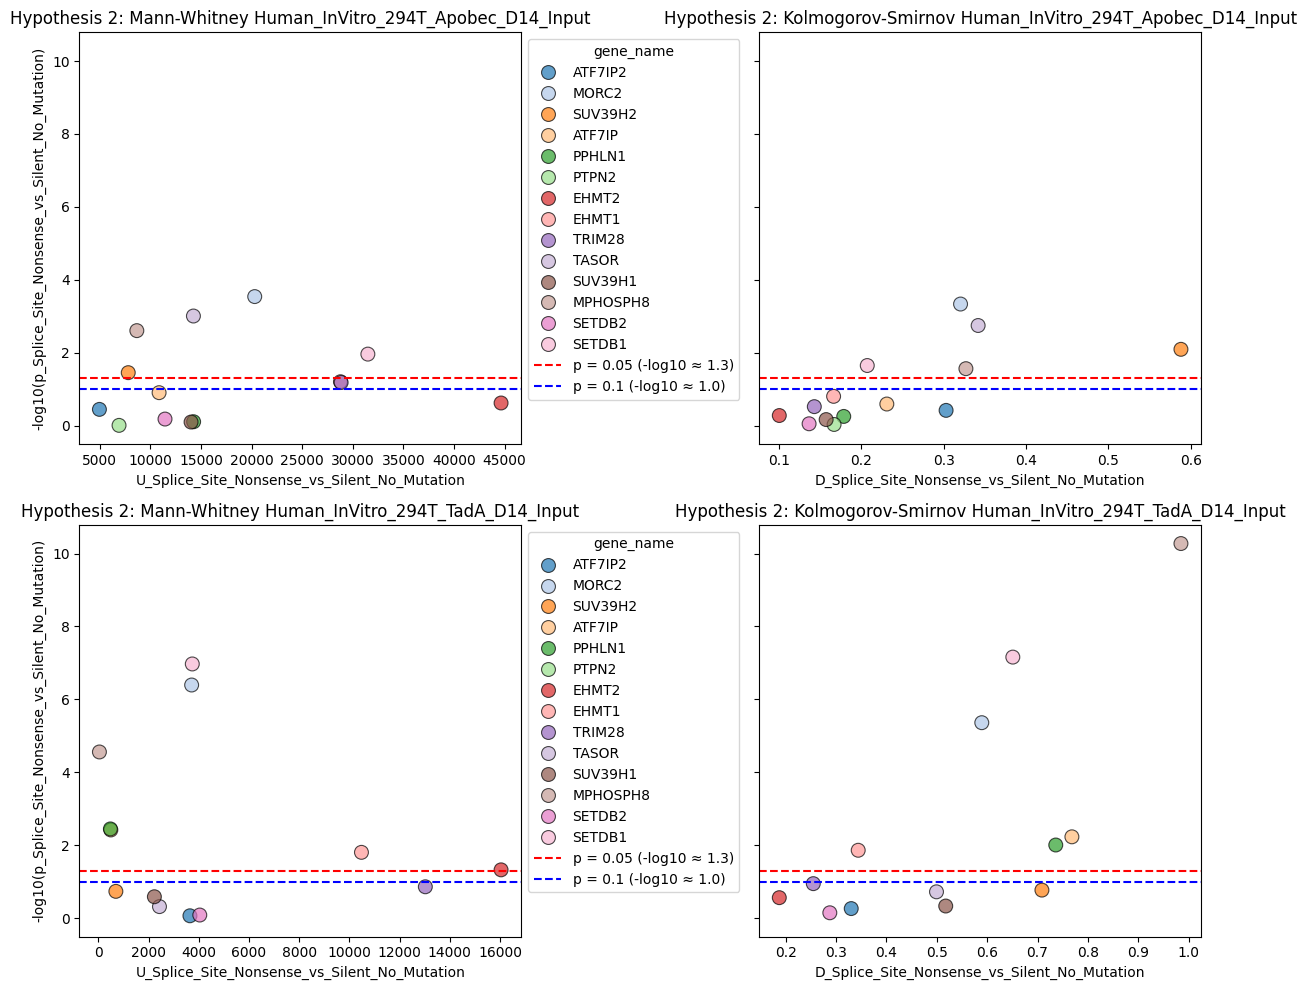

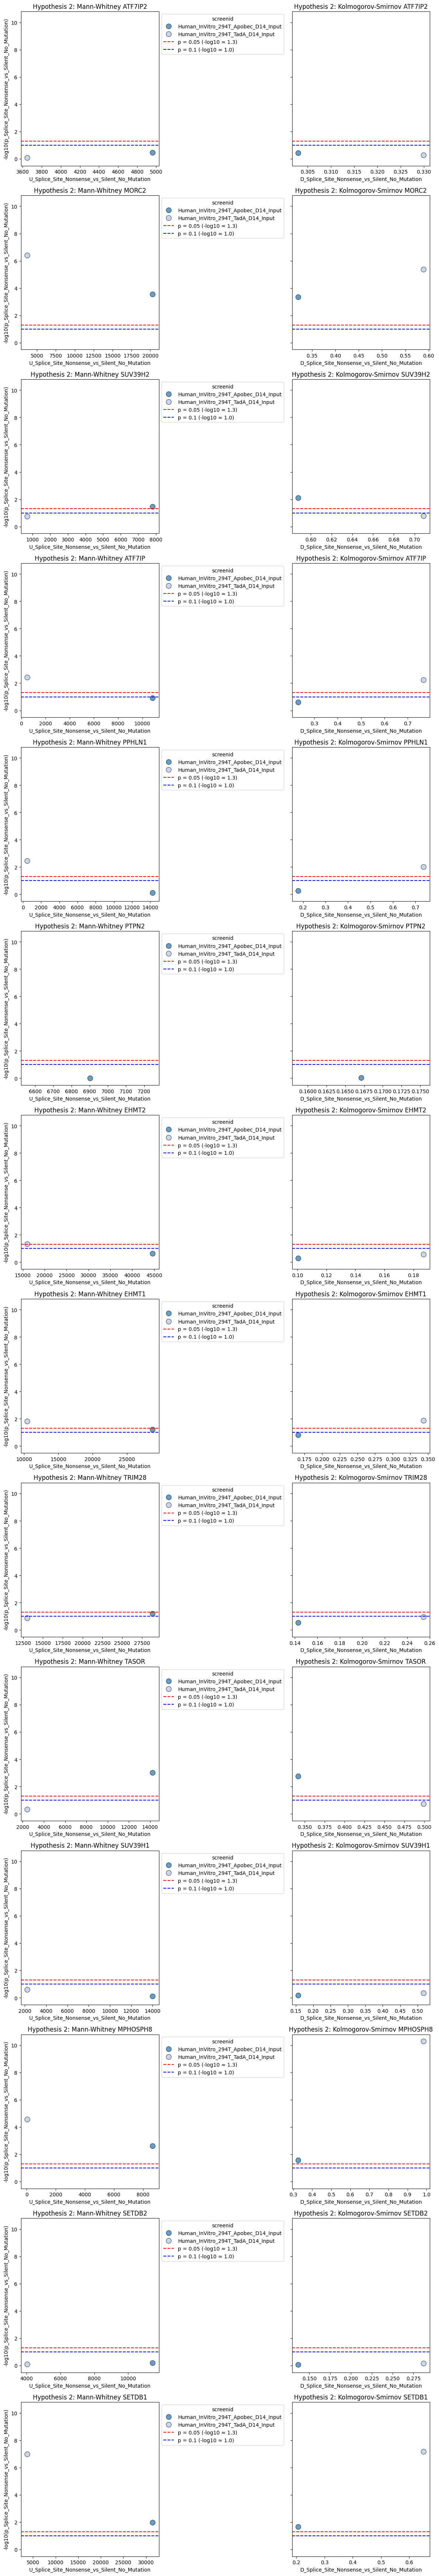

In [15]:
# @markdown Run hypothesis tests

from hypothesis_tests import hypothesis_tests
dfs = [pd.read_csv(f'{workdir}rawdata/{screen}', sep='\t') for screen in screens]

# @markdown Cases
nonsense_case = True # @param {type:"boolean"}
splice_case = True # @param {type:"boolean"}
missense_case = False # @param {type:"boolean"}
intron_case = False # @param {type:"boolean"}
silent_case = False # @param {type:"boolean"}
utr_case = False # @param {type:"boolean"}
flank_case = False # @param {type:"boolean"}
nomutation_case = False # @param {type:"boolean"}
case_bools = [nonsense_case, splice_case, missense_case, intron_case, silent_case, utr_case, flank_case, nomutation_case]

# @markdown Controls
nonsense_control = False # @param {type:"boolean"}
splice_control = False # @param {type:"boolean"}
missense_control = False # @param {type:"boolean"}
intron_control = False # @param {type:"boolean"}
silent_control = True # @param {type:"boolean"}
utr_control = False # @param {type:"boolean"}
flank_control = True # @param {type:"boolean"}
nomutation_control = False # @param {type:"boolean"}
controls_bools = [nonsense_control, splice_control, missense_control, intron_control, silent_control, utr_control, flank_control, nomutation_control]

# cases_dropdown = 'Nonsense' # @param ['Nonsense', 'Splice Site', 'Missense', 'Intron', 'Silent', 'UTR', 'Flank', 'No Mutation'] {type:"raw"}

# cases = 'Splice,Nonsense' # @param {type:"string"}
# controls = 'Silent,No Mutation' # @param {type:"string"}

types = ['Nonsense', 'Splice Site', 'Missense', 'Intron', 'Silent', 'UTR', 'Flank', 'No Mutation']
cases = [typ for typ, boole in zip(types, case_bools) if boole]
controls = [typ for typ, boole in zip(types, controls_bools) if boole]
comp_name = 'Splice_Site_Nonsense_vs_Silent_No_Mutation' # @param {type:"string"}

# MAKE SURE SOME OF INPUT CATEGORIES EXIST IN DATAFRAMES #
for df in dfs:
    mut_types = df[mut_col].unique()
    assert any([cas in mut_types for cas in cases])
    assert any([con in mut_types for con in controls])

print('Cases:', cases)
print('Controls:', controls)
hypothesis_tests(
    df_Inputs=dfs,
    workdir=workdir,
    input_gene=input_gene,
    input_screens=screens,
    cases=cases, controls=controls, comp_name=comp_name,
    mut_col=mut_col, val_col=val_col, gene_col=gene_col,
    )


In [ ]:
# @markdown Randomize screen data

from beclust3d.randomize_be_results import randomize_be_results

screen_names = [screen.split('.')[0] for screen in screens]
df_missenses = [pd.read_csv(f'{workdir}SETDB1/screendata/{input_gene}_{screen_name}_Missense_edits_list.tsv', sep='\t') for screen_name in screen_names]
for df_missense, screen_name in zip(df_missenses, screen_names):
    randomize_be_results(
        df_missense=df_missense,
        workdir=workdir,
        input_gene=input_gene,
        input_screen=screen_name,
        )

In [7]:
# @markdown Query Uniprot and AlphaFold and process files

from beclust3d.af_structural_features import af_structural_features

# @markdown Optional inputs:
user_uniprot = 'drive/MyDrive/beclust3d/SETDB1/Q15047.fasta' # @param {type:"string"}
user_pdb = 'drive/MyDrive/beclust3d/SETDB1/AF_Q15047.pdb' # @param {type:"string"}
user_dssp = 'drive/MyDrive/beclust3d/SETDB1/AF-Q15047-F1-model_v4_processed.dssp' # @param {type:"string"}

af_structural_features(
    workdir=workdir,
    input_gene=input_gene,
    input_uniprot=input_uniprot,
    structureid=structureid,
    # optional
    user_uniprot=user_uniprot, user_pdb=user_pdb, user_dssp=user_dssp,
    )

unipos unires  x_coord  y_coord  z_coord  bfactor_pLDDT  Naa_count  \
0          1      M   40.740   39.109   -6.115          36.75          1   
1          2      S   37.812   38.895   -3.704          32.83          2   
2          3      S   35.498   37.485   -2.174          32.79          2   
3          4      L   32.875   36.126    0.319          42.90          2   
4          5      P   31.112   32.952    1.735          39.74          2   
...      ...    ...      ...      ...      ...            ...        ...   
1286    1287      R    3.341   -6.712  -10.508          85.91          3   
1287    1288      G    5.709   -4.495  -12.671          86.20          6   
1288    1289      R    2.800   -4.128  -15.192          86.79          7   
1289    1290      L   -0.974   -3.633  -15.073          80.70          7   
1290    1291      L   -1.472   -4.669  -18.743          80.88          6   

                Naa                             Naa_pos SS9  ...  ACC   RSA  \
0                 S                                   2   L  ...  233  1.04   
1               M;S                                 1;3   L  ...  103  0.66   
2               S;L                                 2;4   L  ...   99  0.64   
3               S;P                                 3;5   L  ...  165  0.82   
4               L;G                                 4;6   L  ...  115  0.72   
...             ...                                 ...  ..  ...  ...   ...   
1286          C;G;R                      1286;1288;1289   L  ...  104  0.42   
1287    E;D;C;C;R;R       1146;1147;1279;1286;1287;1289   S  ...    9  0.09   
1288  L;L;C;R;G;L;L  1277;1278;1279;1287;1288;1290;1291   B  ...   69  0.28   
1289  Y;V;L;L;C;R;L  1267;1269;1277;1278;1279;1289;1291   L  ...   11  0.05   
1290    V;G;E;L;R;L       1269;1270;1276;1277;1289;1290   L  ...   14  0.07   

        exposure    PHI  normPHI    PSI  normPSI  dBurial  normSumdBurial  \
0        exposed  360.0     2.00  157.3     0.87     0.00           0.000   
1     medexposed   35.4     0.20  133.7     0.74     0.38           0.076   
2     medexposed  179.7     1.00  177.6     0.99     0.40           0.120   
3        exposed   94.0     0.52  156.7     0.87     0.22           0.079   
4     medexposed -102.6    -0.57  165.8     0.92     0.32           0.090   
...          ...    ...      ...    ...      ...      ...             ...   
1286   medburied  -63.4    -0.35   -9.9    -0.06     0.62           0.552   
1287      buried   71.4     0.40  -39.9    -0.22     0.95           0.798   
1288   medburied -126.4    -0.70  162.4     0.90     0.76           0.616   
1289      buried -104.3    -0.58  -44.6    -0.25     0.99           0.733   
1290      buried -122.3    -0.68  360.0     2.00     0.97           0.660   

      pLDDT_dis  
0      very low  
1      very low  
2      very low  
3      very low  
4      very low  
...         ...  
1286  confident  
1287  confident  
1288  confident  
1289  confident  
1290  confident  

[1291 rows x 21 columns]

Human_InVitro_294T_Apobec_D14_Input.txt
Human_InVitro_294T_TadA_D14_Input.txt
Human_InVitro_SK-ES_Apobec_D14_Input.txt
Human_InVitro_SK-ES_TadA_D17_Input.txt
Human_InVitro_SW480_Apobec_D14_Input.txt
Human_InVitro_SW480_TadA_D14_Input.txt
Mouse_InVivo_B16_Apobec_NSG_Input.txt
Mouse_InVivo_B16_Apobec_Tx_NSG.txt
Mouse_InVivo_B16_TadA_NSG_Input.txt
Mouse_InVivo_B16_TadA_Tx_NSG.txt
Mouse_InVivo_LLC_Apobec_NSG_Input.txt


/usr/local/lib/python3.10/dist-packages/beclust3d/prioritize_by_conservation.py:130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 4))


Mouse_InVivo_LLC_Apobec_Tx_NSG.txt


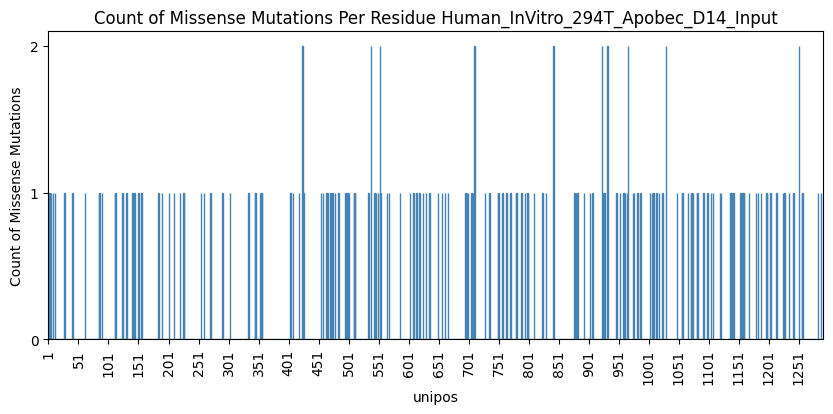

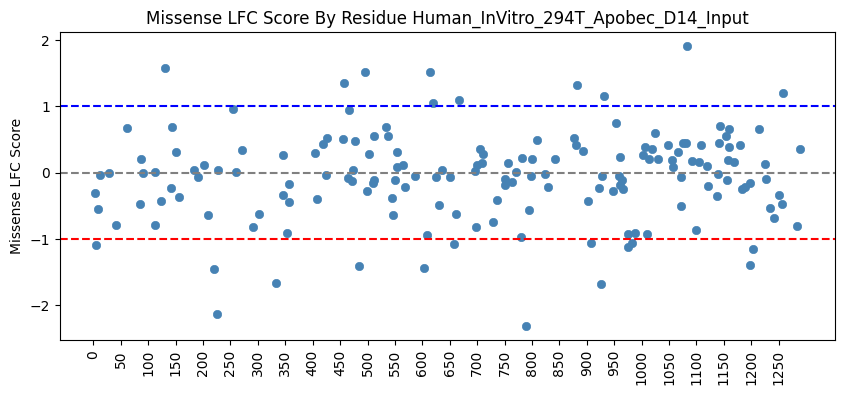

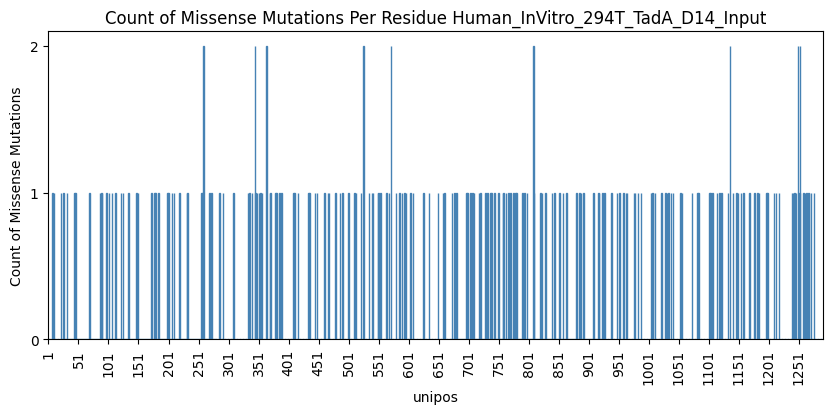

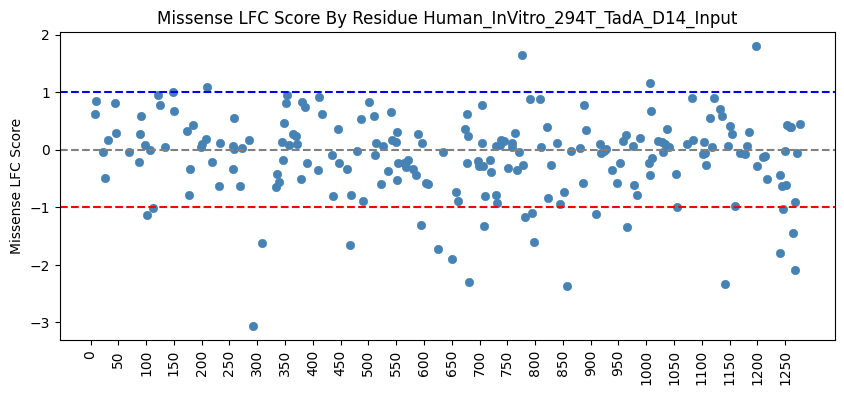

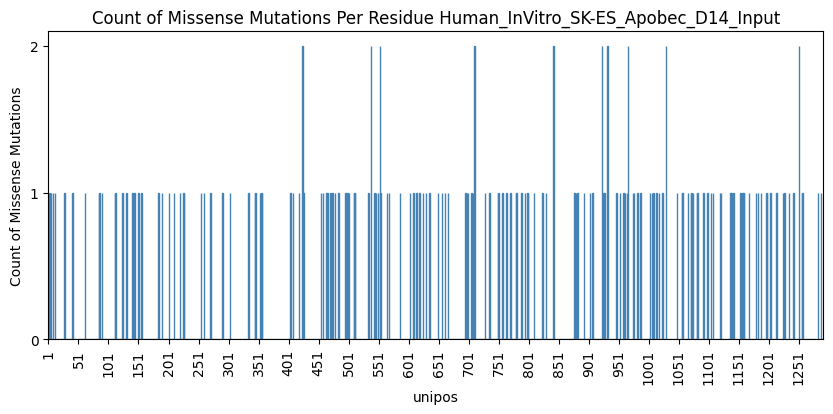

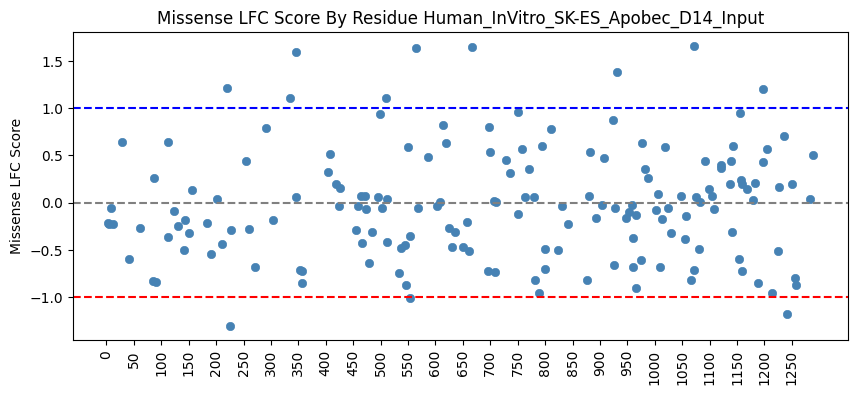

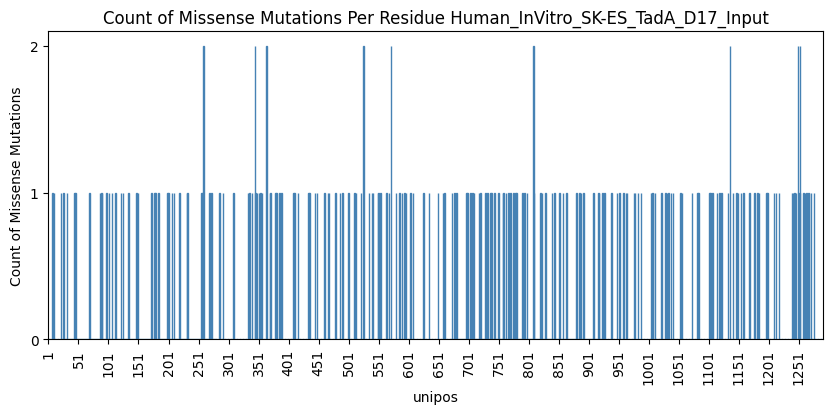

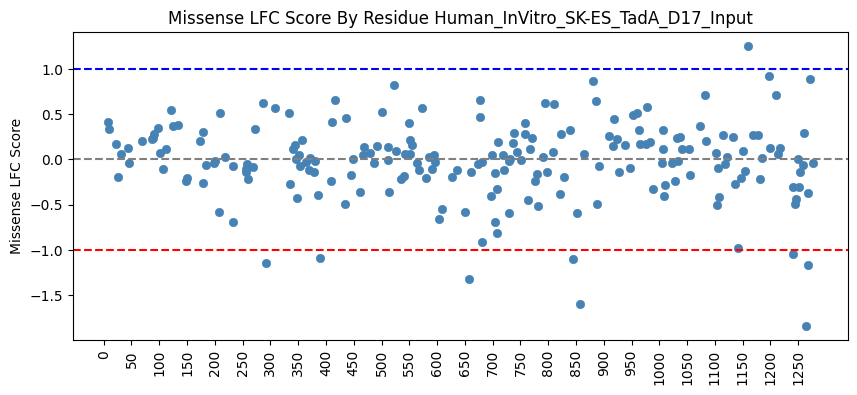

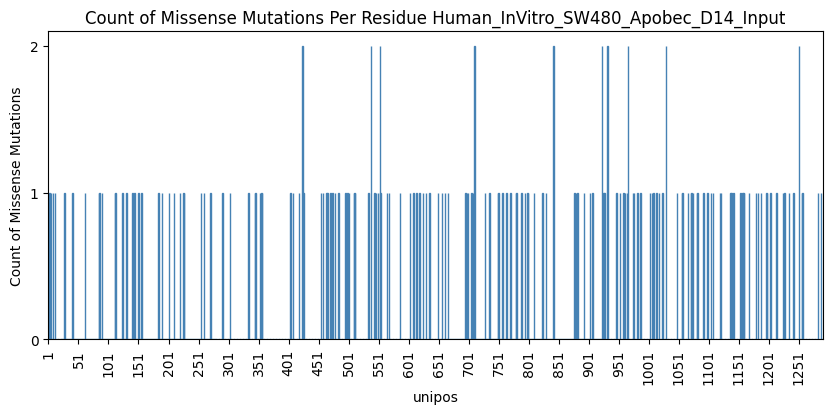

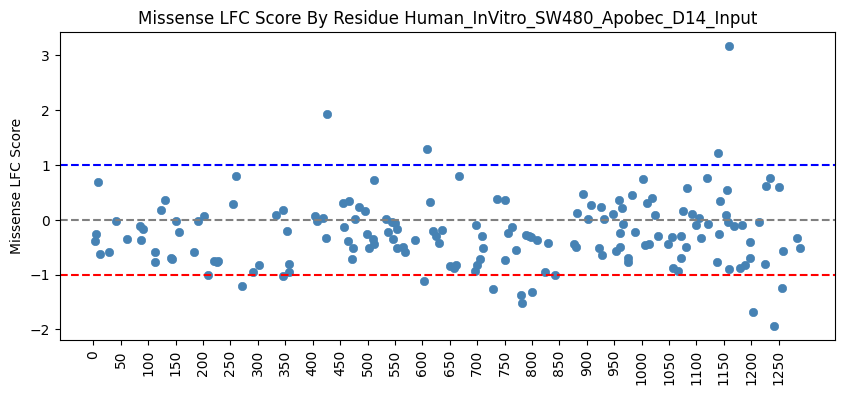

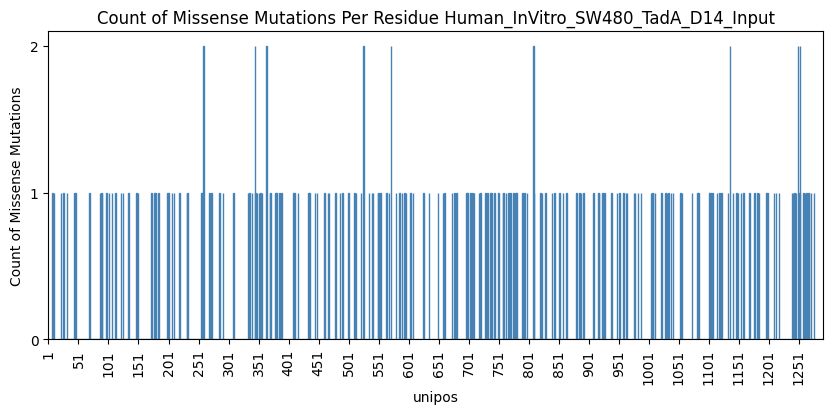

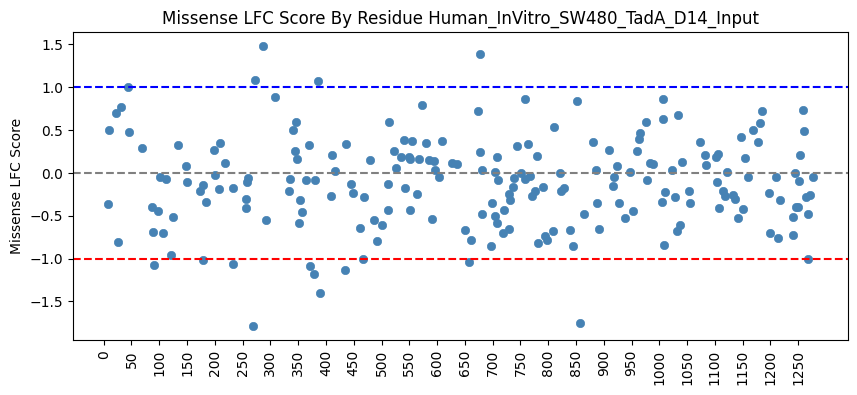

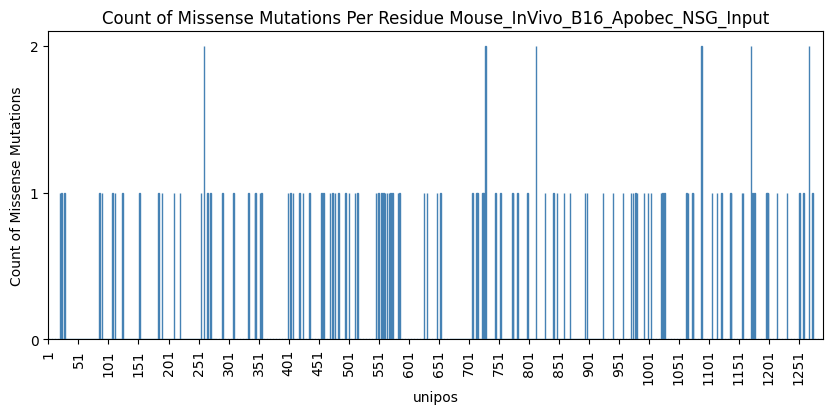

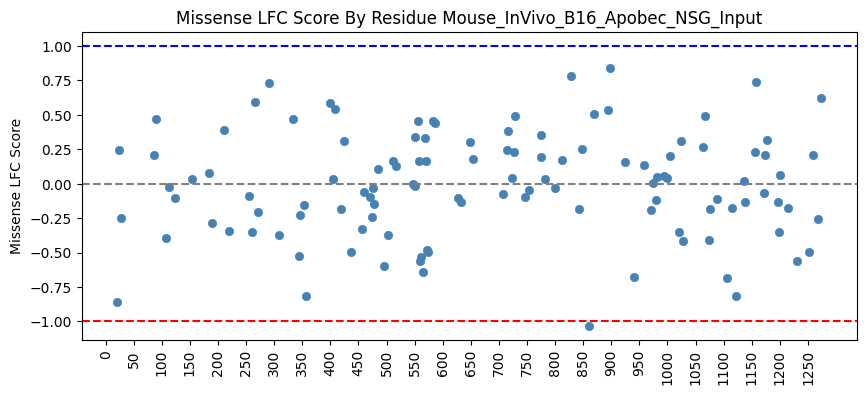

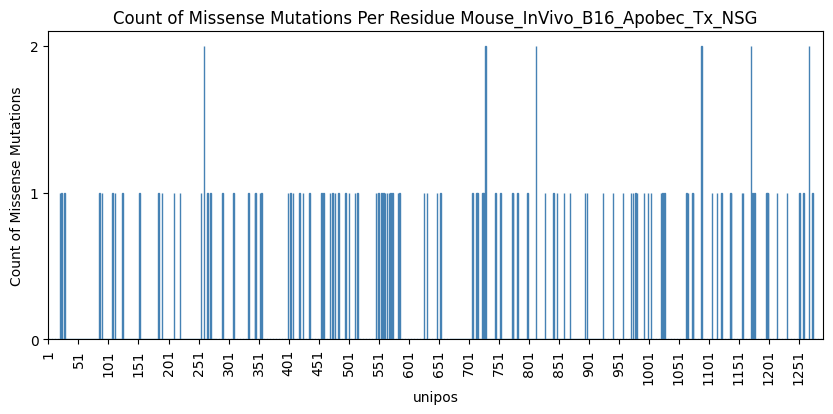

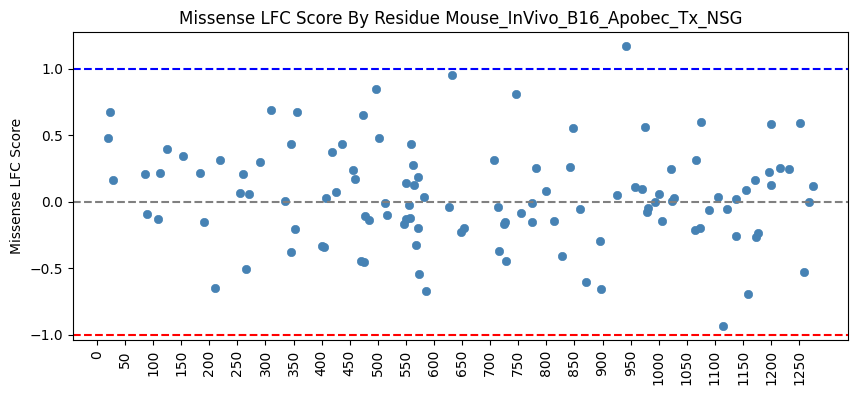

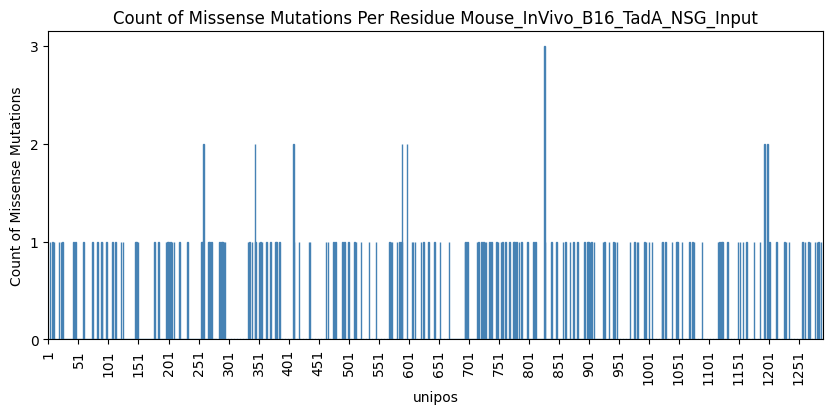

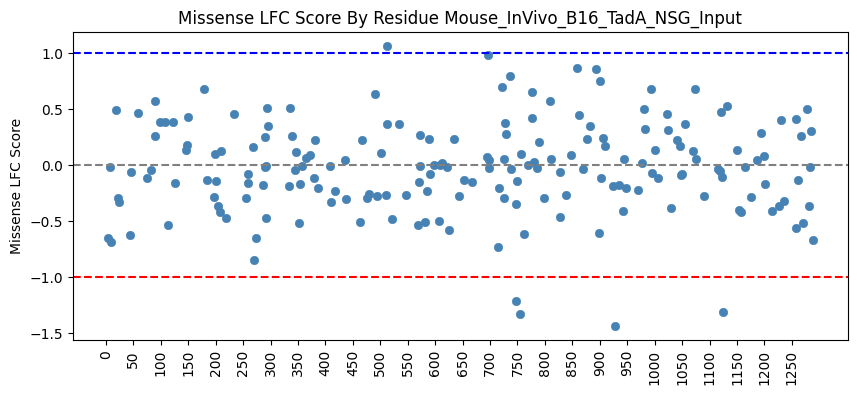

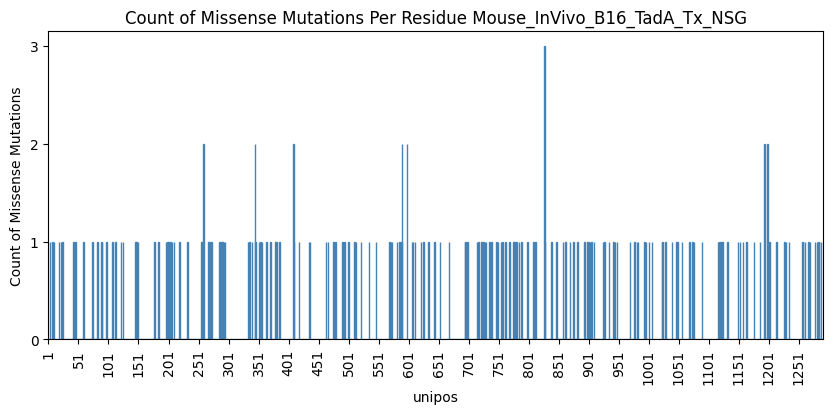

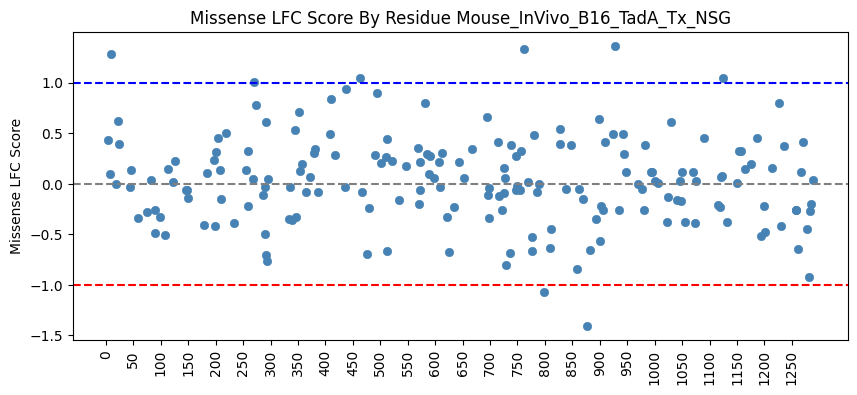

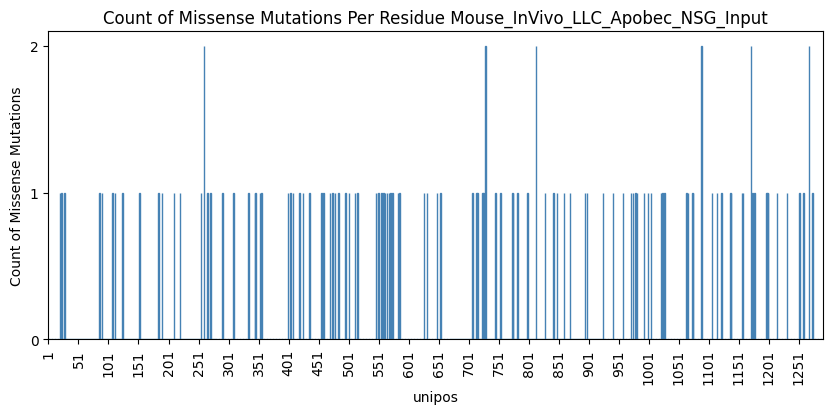

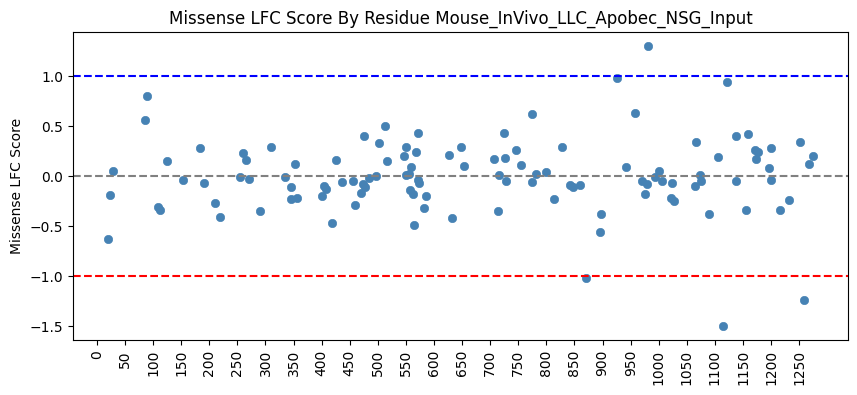

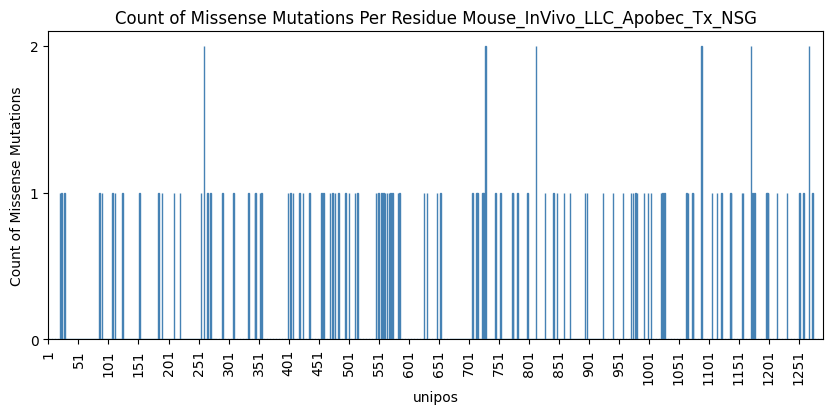

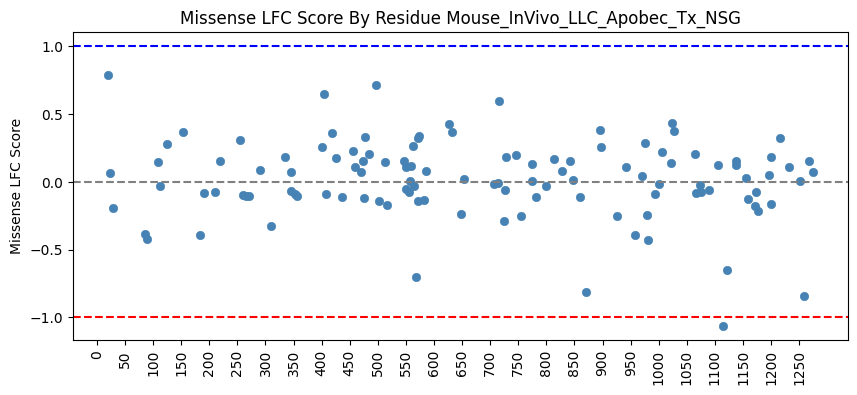

In [ ]:
# @markdown Prioritize screen data by conservation \
# @markdown Optional: Query conservation MUSCLE

include_conservation = False #@param {type:"boolean"}

from beclust3d.prioritize_by_conservation import prioritize_by_conservation

df_struc = pd.read_csv(f"{workdir}{input_gene}/{structureid}_coord_struc_features.tsv", sep = "\t")
if include_conservation:
  from beclust3d.conservation import conservation

  # @markdown Optional Inputs
  input_mouse_gene = 'Setdb1' # @param {type:"string"}
  input_mouse_uniid = 'D3YYC3' # @param {type:"string"}
  email = 'xiaohu@g.harvard.edu' # @param {type:"string"}
  title = 'samplejob' # @param {type:"string"}

  df_alignconserv, df_residuemap = conservation(
      workdir=workdir,
      input_human_gene=input_gene, input_mouse_gene=input_mouse_gene,
      input_human_uniid=input_uniprot, input_mouse_uniid=input_mouse_uniid,
      email=email, title=title,
      )

  df_consrv = pd.read_csv(f"{workdir}{input_gene}/Human{input_gene}_MouseSetdb1_residuemap_conservation.tsv", sep = '\t')
else:
  df_consrv = None

for screen in screens:
    print(screen)
    out_df = prioritize_by_conservation(
            df_struc     =df_struc,
            df_consrv    =df_consrv,
            workdir      =workdir,
            input_gene   =input_gene,
            input_screen =screen,
            structureid  =structureid,
        )

In [ ]:
# @markdown Randomize screen data prioritized by conservation

from beclust3d.randomize_by_conservation import randomize_by_conservation

for screen in screens:
    out_df = randomize_by_conservation(
        workdir      =workdir,
        input_gene   =input_gene,
        input_screen =screen,
        structureid  =structureid,
    )

# Calculate 3D LFC Scores and